## US presidential elections model

How do macro economic and social features influence US presidential election outcomes

### Imports

In [5]:
# Misc system tools
from pathlib import Path
import subprocess 
# Data tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# ML models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
# Internal modules
from train import Train
from analyse import Analyse
# Apply matplotlib style
style_path = Path(__file__).parent / "plot.mplstyle" if "__file__" in globals() else Path("plot.mplstyle")
plt.style.use(style_path)

## Load preprocessed data

`code/process_data.py` runs preprocessing

Contains merged data from three sources (1960-2020):
- Election outcomes (winner, party, lean, label)
- World Bank macroeconomic indicators (GDP growth, inflation, trade balance, etc.)
- FRED unemployment rates (monthly data aggregated to yearly averages)

Missing values handled by:
- Dropping columns with >50% missing data
- Linear interpolation for remaining gaps
- Dropping any columns that still have missing values after interpolation

In [6]:
file_path = "../data/proc/data.csv"
reprocess = False 
if not Path(file_path).is_file() or reprocess:
    subprocess.run(["python3", "process_data.py"])  
df = pd.read_csv(file_path)
display(df)

,Year,Winner,Party,EC,PV,Lean,Era,Label,index,"Population, total",...,Mobile cellular subscriptions (per 100 people),Merchandise trade (% of GDP),Net barter terms of trade index (2015 = 100),Net migration,"Personal remittances, paid (current US$)","Foreign direct investment, net inflows (BoP, current US$)",GDP per capita (current US$),"Foreign direct investment, net (BoP, current US$)","Inflation, consumer prices (annual %)",Unemployment
0,2024,Donald Trump,Republican,0.4200,0.4834,Right,Populist,1,64,334914895,...,104.935375,18.733583,100.000000,1322668,9.303100e+10,3.487840e+11,82769.412210,0.105300,4.116338,4.027273
1,2020,Joseph Biden,Democratic,0.5688,0.5131,Left,Populist,0,61,331526933,...,104.935375,17.944405,100.000000,329769,6.612600e+10,1.370660e+11,64411.373180,0.145265,1.233584,8.091667
2,2016,Donald Trump,Republican,0.5690,0.4620,Right,Populist,1,57,323071755,...,103.370250,19.681904,100.083472,1889129,6.287000e+10,4.743880e+11,58206.614190,-0.174573,1.261583,4.875000
3,2012,Barack Obama,Democratic,0.6170,0.5110,Left,Partisan Polarisation,0,53,313877662,...,96.269297,23.884792,94.680851,1632007,5.237100e+10,2.503450e+11,51784.411470,0.126895,2.069337,8.075000
4,2008,Barack Obama,Democratic,0.6780,0.5290,Left,Partisan Polarisation,0,49,304093966,...,85.477380,23.405290,91.797166,1416841,5.567900e+10,3.410920e+11,48570.059430,0.002491,3.839100,5.800000
5,2004,George W. Bush,Republican,0.5320,0.5070,Right,Partisan Polarisation,1,45,292805298,...,62.874751,19.157874,101.270772,1313467,4.435700e+10,2.136410e+11,41724.641200,0.160363,2.677237,5.541667
6,2000,George W. Bush,Republican,0.5040,0.4790,Right,Post-Cold War,1,41,282162411,...,38.767207,19.912473,100.000000,1248392,3.439700e+10,3.491250e+11,36329.970260,-0.162755,3.376857,3.966667
7,1996,William Clinton,Democratic,0.7040,0.4920,Left,Post-Cold War,0,37,269394000,...,16.373812,17.924887,103.448276,1141648,2.372320e+10,9.766000e+10,29967.712720,0.005360,2.931204,5.408333
8,1992,William Clinton,Democratic,0.6880,0.4300,Left,Post-Cold War,0,33,256514000,...,4.323597,15.368646,103.603604,1304880,1.615630e+10,3.031000e+10,25418.990780,0.028460,3.028820,7.491667
9,1988,George Bush,Republican,0.7920,0.5340,Right,Post-1960s Realignment,1,29,244499000,...,0.854125,14.933243,103.960396,460778,9.005000e+09,5.691000e+10,21417.011930,-0.035209,4.077741,5.491667


## Analyse features

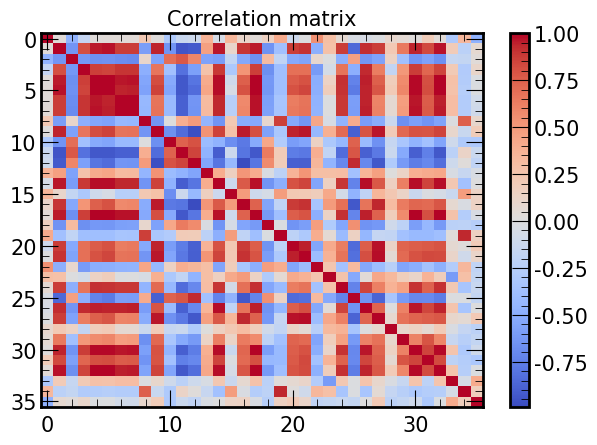

,Feature,Correlation
0,Label,1.000000
1,Gross capital formation (% of GDP),0.544342
2,"Inflation, GDP deflator (annual %)",0.412917
3,"Immunization, measles (% of children ages 12-2...",0.367727
4,Energy use (kg of oil equivalent per capita),0.340180
5,"Inflation, consumer prices (annual %)",0.333160
6,"Revenue, excluding grants (% of GDP)",0.288543
7,Income share held by lowest 20%,0.222303
8,"Foreign direct investment, net inflows (BoP, c...",0.186706
9,GDP growth (annual %),0.145926


✅ Wrote ../results/correlation_with_label.csv


In [7]:
# Analyse correlations with target variable
exclude_columns = ["Year", "Winner", "Party", "EC", "PV", "Era", "Lean", "index"]
df_train = df.drop(columns=exclude_columns)

# Calculate correlation matrix
corr_matrix = df_train.corr()

# Plot
plt.figure()
plt.imshow(corr_matrix, cmap="coolwarm", aspect="auto")
plt.colorbar()
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

# Show correlations with target label
corr_with_label = corr_matrix["Label"].sort_values(ascending=False)
corr_df = pd.DataFrame({
    "Feature": corr_with_label.index,
    "Correlation": corr_with_label.values
})

display(corr_df)

file_name = Path("../results/correlation_with_label.csv")
file_name.parent.mkdir(exist_ok=True)
corr_df.to_csv(file_name, index=False)
print(f"✅ Wrote {file_name}")

In [8]:
X = df_train.drop(columns=["Label"])
y = df_train["Label"]

print(f"{X.shape[1]} features, {X.shape[0]} samples")

35 features, 17 samples


## Containers

In [9]:
metrics = {}
results = {}

## Baseline logitistic regression


In [10]:
trainer = Train(X=X, y=y, model=LogisticRegression)

>**Note:** This baseline model is quite unstable. With only 17 elections and a 20% test split (3-4 elections), which specific elections end up in the test set dramatically affects performance. This is why LOOCV is used below for more reliable evaluation.

🚀 Training model: LogisticRegression
  Tag: lr-base
  Random state: 42
  Leave-One-Out CV: False
  Test size: 0.2
  Save output: False
  hyperparams: {}

  Test size: 0.2

✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,2,0
True 1,1,1



⭐ Classification report:



,precision,recall,f1-score,support
0,0.666667,1.00,0.800000,2.00
1,1.000000,0.50,0.666667,2.00
accuracy,0.750000,0.75,0.750000,0.75
macro avg,0.833333,0.75,0.733333,4.00
weighted avg,0.833333,0.75,0.733333,4.00



⭐ ROC curve & feature importance:

✅ Wrote ../images/lr-base/roc_curve.png


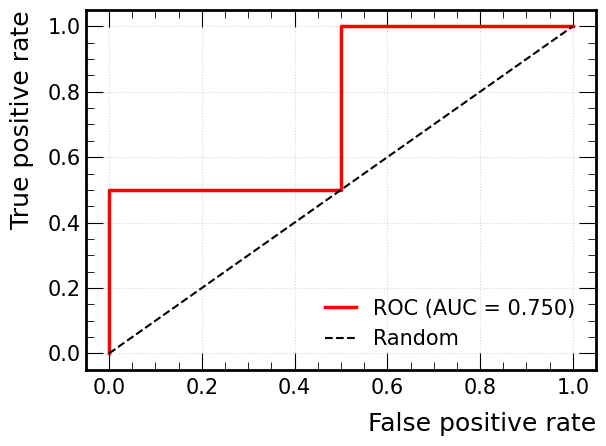

✅ Wrote ../images/lr-base/feature_importance.png


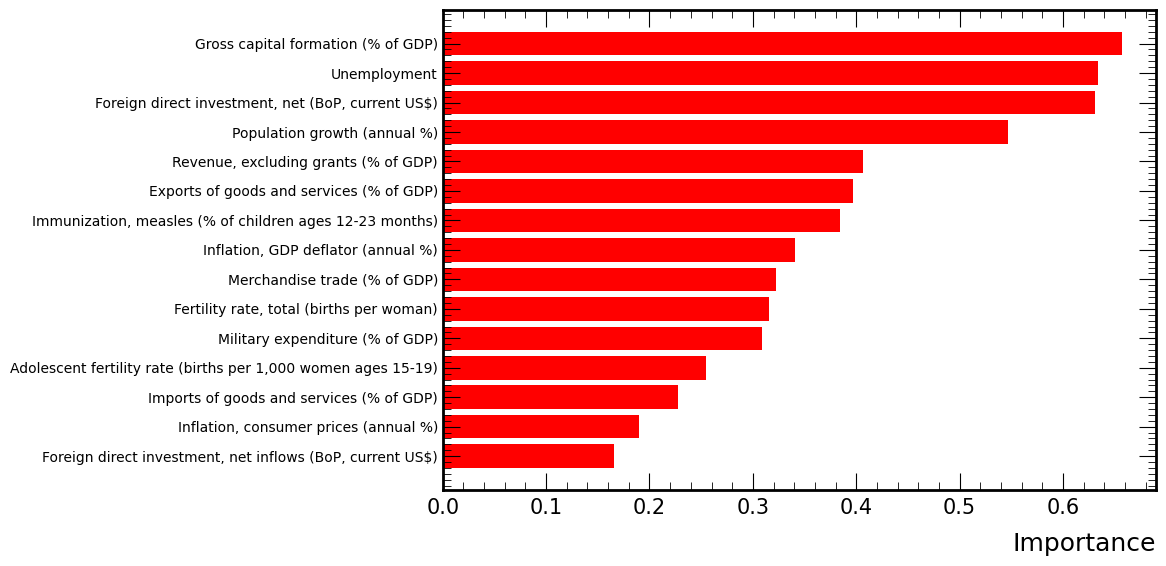

,Feature,Importance
21,Gross capital formation (% of GDP),0.657139
34,Unemployment,0.633450
32,"Foreign direct investment, net (BoP, current US$)",0.630685
1,Population growth (annual %),0.546781
22,"Revenue, excluding grants (% of GDP)",0.406669
19,Exports of goods and services (% of GDP),0.396941
12,"Immunization, measles (% of children ages 12-2...",0.384198
18,"Inflation, GDP deflator (annual %)",0.340719
26,Merchandise trade (% of GDP),0.322780
9,"Fertility rate, total (births per woman)",0.315426


In [11]:
tag = "lr-base"
# Train model
_results = trainer.train(
    loocv=False,
    random_state=42,
    test_size=0.2,
    tag = tag,
)
# Analyse and store metrics
_ = Analyse(_results).execute(X=X, save_output=True)

## Logistic regression with leave-one-out cross validation (LOOCV)

Run with a test size of one in all combinations and get the average performance.

🚀 Training model: LogisticRegression
  Tag: lr-loocv
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: True
  hyperparams: {}

✅ Training complete.

✅ Results saved to ../results/lr-loocv/results.pkl
⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,5,3
True 1,4,5



⭐ Classification report:



,precision,recall,f1-score,support
0,0.555556,0.625000,0.588235,8.000000
1,0.625000,0.555556,0.588235,9.000000
accuracy,0.588235,0.588235,0.588235,0.588235
macro avg,0.590278,0.590278,0.588235,17.000000
weighted avg,0.592320,0.588235,0.588235,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/lr-loocv/roc_curve.png


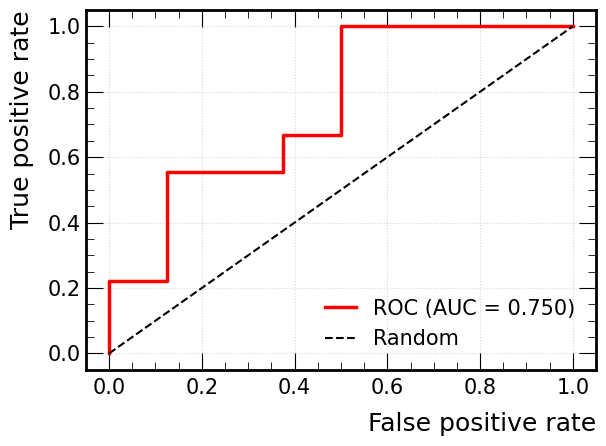

✅ Wrote ../images/lr-loocv/feature_importance.png


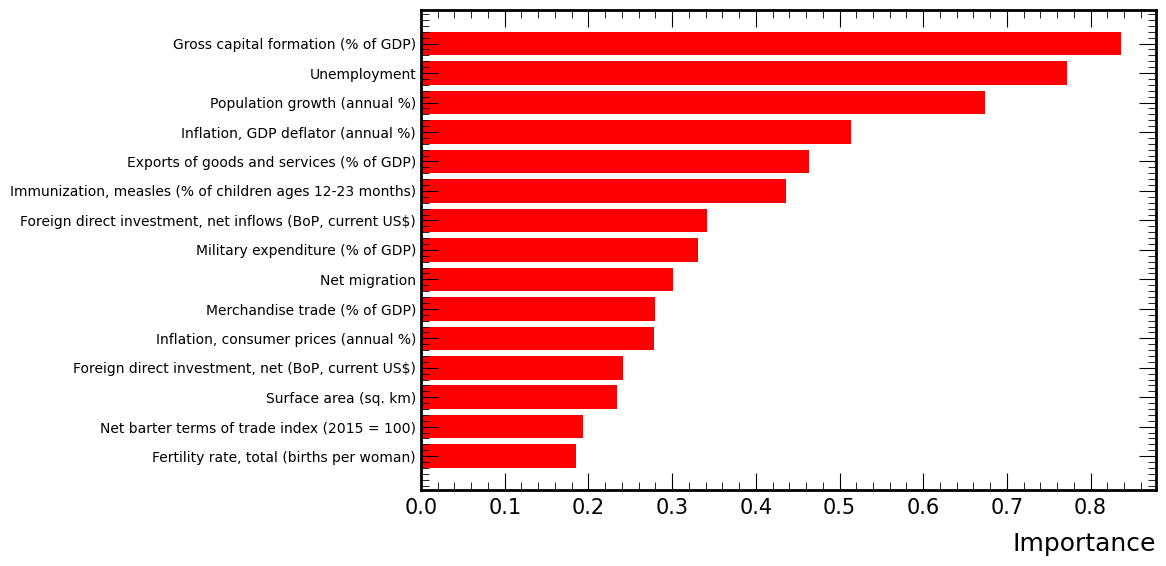

,Feature,Importance
21,Gross capital formation (% of GDP),0.836254
34,Unemployment,0.771661
1,Population growth (annual %),0.673770
18,"Inflation, GDP deflator (annual %)",0.513359
19,Exports of goods and services (% of GDP),0.463895
12,"Immunization, measles (% of children ages 12-2...",0.436467
30,"Foreign direct investment, net inflows (BoP, c...",0.341997
24,Military expenditure (% of GDP),0.330602
28,Net migration,0.301118
26,Merchandise trade (% of GDP),0.278992


In [12]:
tag = "lr-loocv"
results[tag] = trainer.train(
    loocv=True,
    random_state=42,
    tag = tag, 
    save_output=True
)
metrics[tag] = Analyse(results[tag]).execute(X=X, save_output=True) 

## Random forest classifier with LOOCV

🚀 Training model: RandomForestClassifier
  Tag: rf-loocv
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: True
  hyperparams: {}

✅ Training complete.

✅ Results saved to ../results/rf-loocv/results.pkl
⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,4,4
True 1,4,5



⭐ Classification report:



,precision,recall,f1-score,support
0,0.500000,0.500000,0.500000,8.000000
1,0.555556,0.555556,0.555556,9.000000
accuracy,0.529412,0.529412,0.529412,0.529412
macro avg,0.527778,0.527778,0.527778,17.000000
weighted avg,0.529412,0.529412,0.529412,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/rf-loocv/roc_curve.png


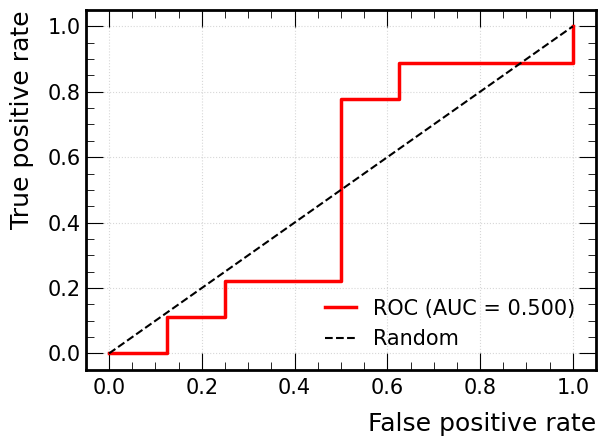

✅ Wrote ../images/rf-loocv/feature_importance.png


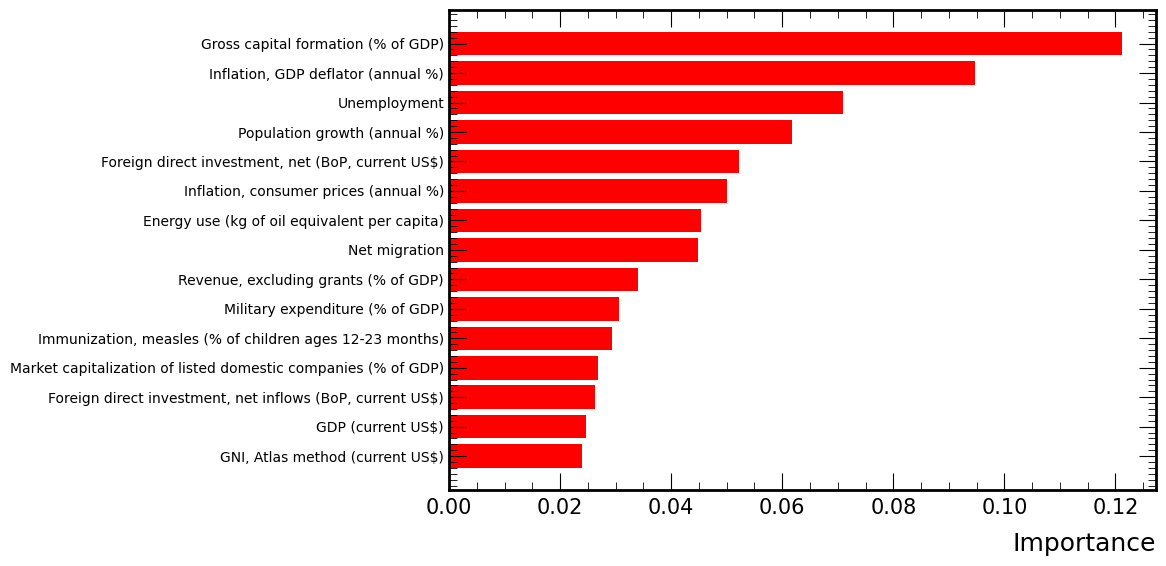

,Feature,Importance
21,Gross capital formation (% of GDP),0.121234
18,"Inflation, GDP deflator (annual %)",0.094792
34,Unemployment,0.070873
1,Population growth (annual %),0.061769
32,"Foreign direct investment, net (BoP, current US$)",0.052231
33,"Inflation, consumer prices (annual %)",0.050027
14,Energy use (kg of oil equivalent per capita),0.045384
28,Net migration,0.044825
22,"Revenue, excluding grants (% of GDP)",0.033995
24,Military expenditure (% of GDP),0.030685


In [13]:
trainer = Train(X=X, y=y, model=RandomForestClassifier)

tag = "rf-loocv"
results[tag] = trainer.train(
    loocv=True,
    random_state=42,
    tag = tag, 
    save_output=True
)
# Analysis
metrics[tag] = Analyse(results[tag]).execute(X=X, save_output=True) 

## Support vector machines with LOOCV

🚀 Training model: SVC
  Tag: svc-loocv
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: True
  hyperparams: {'probability': True, 'kernel': 'linear'}

✅ Training complete.

✅ Results saved to ../results/svc-loocv/results.pkl
⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,5,3
True 1,4,5



⭐ Classification report:



,precision,recall,f1-score,support
0,0.555556,0.625000,0.588235,8.000000
1,0.625000,0.555556,0.588235,9.000000
accuracy,0.588235,0.588235,0.588235,0.588235
macro avg,0.590278,0.590278,0.588235,17.000000
weighted avg,0.592320,0.588235,0.588235,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/svc-loocv/roc_curve.png


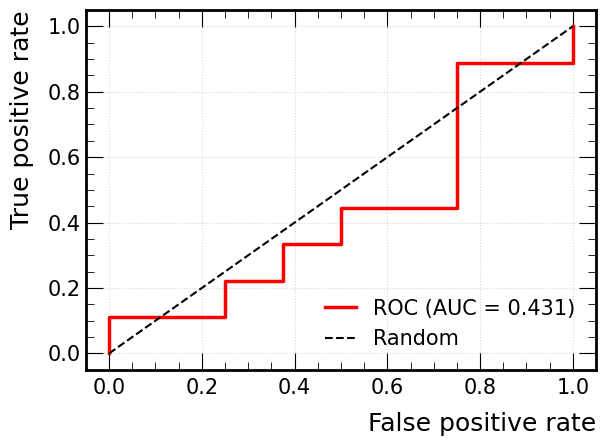

✅ Wrote ../images/svc-loocv/feature_importance.png


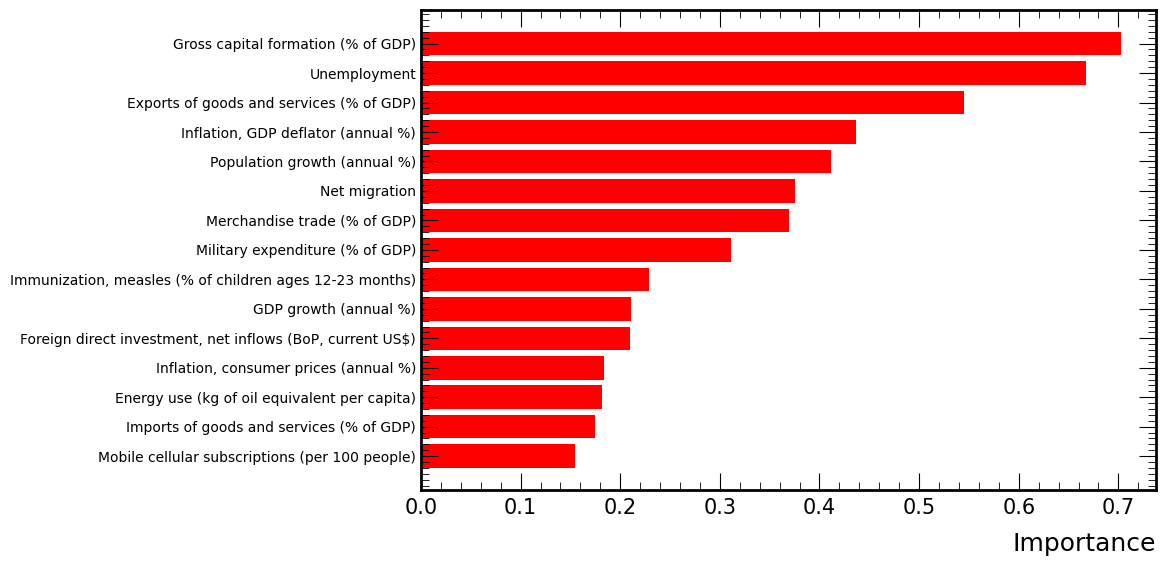

,Feature,Importance
21,Gross capital formation (% of GDP),0.702628
34,Unemployment,0.667831
19,Exports of goods and services (% of GDP),0.544772
18,"Inflation, GDP deflator (annual %)",0.436267
1,Population growth (annual %),0.411428
28,Net migration,0.375215
26,Merchandise trade (% of GDP),0.369780
24,Military expenditure (% of GDP),0.311200
12,"Immunization, measles (% of children ages 12-2...",0.228899
17,GDP growth (annual %),0.211118


In [14]:
trainer = Train(X=X, y=y, model=SVC)
tag = "svc-loocv"
results[tag] = trainer.train(
    loocv=True,
    random_state=42,
    tag = tag,
    probability=True,
    kernel="linear",
    save_output=True

)
# Analysis
metrics[tag] = Analyse(results[tag]).execute(X=X, save_output=True)

## Gradient boosted decision tree with LOOCV

🚀 Training model: XGBClassifier
  Tag: xgb-loocv
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: True
  hyperparams: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

✅ Training complete.

✅ Results saved to ../results/xgb-loocv/results.pkl
⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,4,4
True 1,3,6



⭐ Classification report:



,precision,recall,f1-score,support
0,0.571429,0.500000,0.533333,8.000000
1,0.600000,0.666667,0.631579,9.000000
accuracy,0.588235,0.588235,0.588235,0.588235
macro avg,0.585714,0.583333,0.582456,17.000000
weighted avg,0.586555,0.588235,0.585346,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/xgb-loocv/roc_curve.png


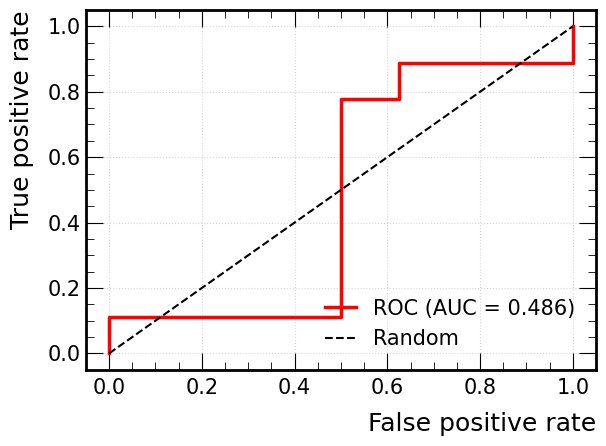

✅ Wrote ../images/xgb-loocv/feature_importance.png


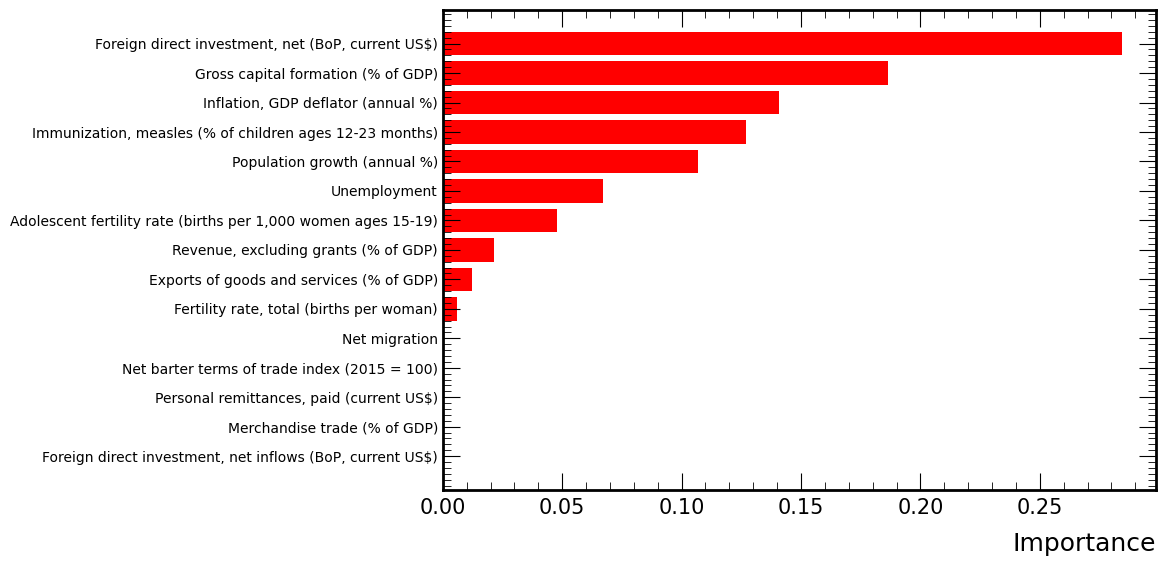

,Feature,Importance
32,"Foreign direct investment, net (BoP, current US$)",0.284411
21,Gross capital formation (% of GDP),0.186477
18,"Inflation, GDP deflator (annual %)",0.140743
12,"Immunization, measles (% of children ages 12-2...",0.126811
1,Population growth (annual %),0.107054
34,Unemployment,0.067179
10,"Adolescent fertility rate (births per 1,000 wo...",0.047687
22,"Revenue, excluding grants (% of GDP)",0.021264
19,Exports of goods and services (% of GDP),0.012385
9,"Fertility rate, total (births per woman)",0.005988


In [15]:
trainer = Train(X=X, y=y, model=XGBClassifier)
tag = "xgb-loocv"
results[tag] = trainer.train(
    loocv=True,
    random_state=42,
    tag=tag,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    save_output=True
)
# Analysis
metrics[tag] = Analyse(results[tag]).execute(X=X, save_output=True) 

## Compare performance

✅ Wrote ../images/metrics_comparison.png


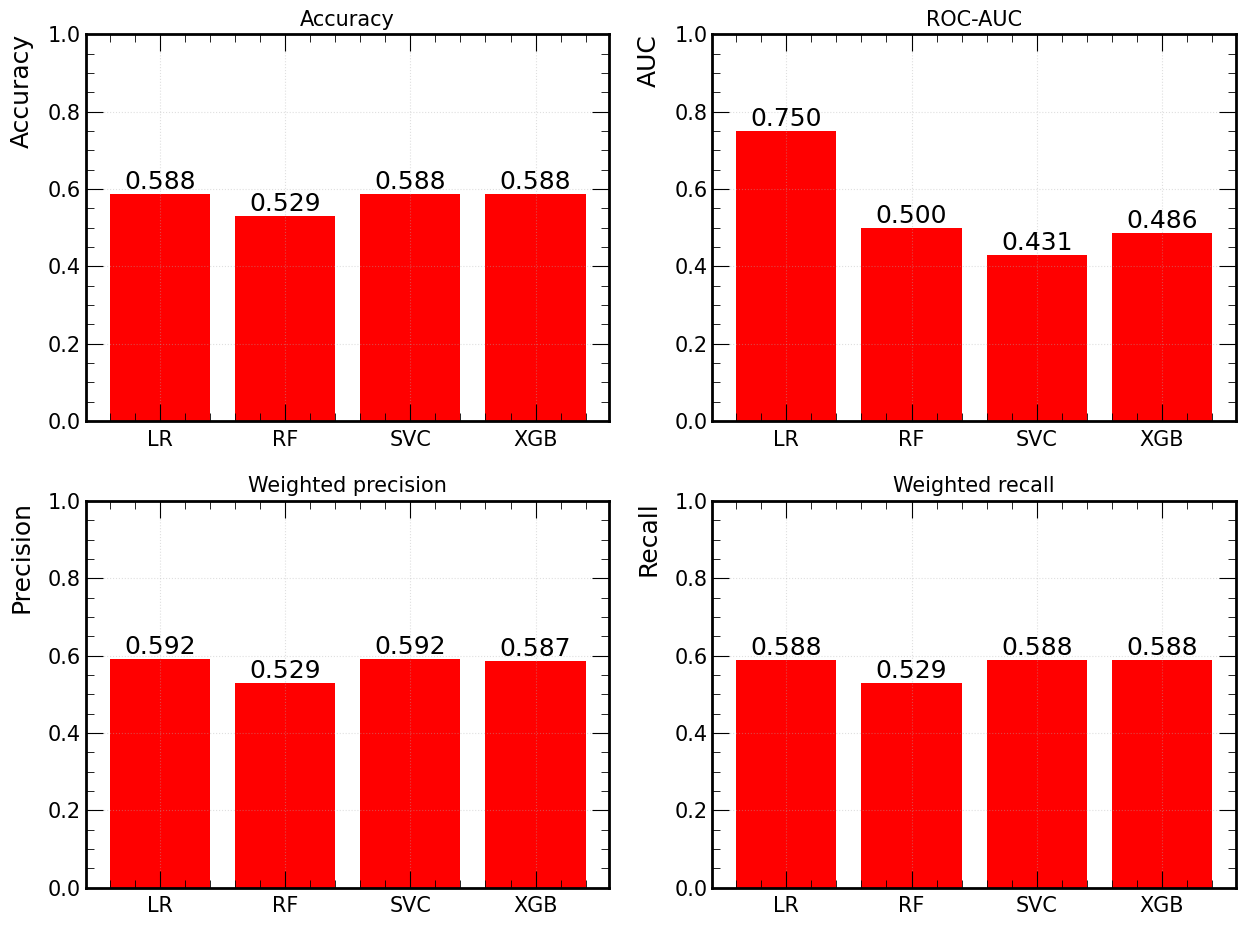

In [16]:
# Bar charts of multiple metrics for each model
df_metrics = pd.DataFrame(metrics).T

fig, ax = plt.subplots(2, 2, figsize=(2*6.4, 2*4.8))

labels = ["LR", "RF", "SVC", "XGB"]
acc = []
auc = []
precision = []
recall = []

for x in metrics.values():
    report = x["report"]
    acc.append(report.loc["accuracy", "precision"])
    auc.append(x["roc"]["auc"])
    # Weighted average of precision and recall across classes
    precision.append(report.loc["weighted avg", "precision"])
    recall.append(report.loc["weighted avg", "recall"])

# Plot accuracy
bars = ax[0, 0].bar(labels, acc)
ax[0, 0].set_ylabel("Accuracy")
ax[0, 0].set_ylim([0, 1])
ax[0, 0].set_title("Accuracy")
ax[0, 0].grid(alpha=0.4)
for bar in bars:
    height = bar.get_height()
    ax[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                  f"{height:.3f}", ha="center", va="bottom")

# Plot AUC
bars = ax[0, 1].bar(labels, auc)
ax[0, 1].set_ylabel("AUC")
ax[0, 1].set_ylim([0, 1])
ax[0, 1].set_title("ROC-AUC")
ax[0, 1].grid(alpha=0.4)
for bar in bars:
    height = bar.get_height()
    ax[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                  f"{height:.3f}", ha="center", va="bottom") #, fontsize=9)

# Plot Precision
bars = ax[1, 0].bar(labels, precision)
ax[1, 0].set_ylabel("Precision")
ax[1, 0].set_ylim([0, 1])
ax[1, 0].set_title("Weighted precision")
ax[1, 0].grid(alpha=0.4)
for bar in bars:
    height = bar.get_height()
    ax[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                  f"{height:.3f}", ha="center", va="bottom") #, fontsize=9)

# Plot Recall
bars = ax[1, 1].bar(labels, recall)
ax[1, 1].set_ylabel("Recall")
ax[1, 1].set_ylim([0, 1])
ax[1, 1].set_title("Weighted recall")
ax[1, 1].grid(alpha=0.4)
for bar in bars:
    height = bar.get_height()
    ax[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                  f"{height:.3f}", ha="center", va="bottom") #, fontsize=9)

plt.tight_layout()

file_name = "../images/metrics_comparison.png"
plt.savefig(file_name)
print(f"✅ Wrote {file_name}")
plt.show()

## Optimisation

Based on this, logistic regression is likely the most reliable approach. But, we should try to optimise each approach and see what happens.  

Feature engineering

* Reduce the number of features 
* Try interaction terms
* Recursive feature elimination

Hyperparameter tuning with grid search

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 10 features based on ANOVA F-statistic
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected features:")
for feature in selected_features:
    print(f":{feature}")

Selected features:
:Population growth (annual %)
:Fertility rate, total (births per woman)
:Immunization, measles (% of children ages 12-23 months)
:Energy use (kg of oil equivalent per capita)
:Inflation, GDP deflator (annual %)
:Gross capital formation (% of GDP)
:Revenue, excluding grants (% of GDP)
:Foreign direct investment, net (BoP, current US$)
:Inflation, consumer prices (annual %)
:Unemployment


In [18]:
# More readable feature names
new_feature_names = ["Population growth [%]",
 "Fertility rate [births per woman]",
 "Measles immunisation [% children 12-23 months]",
 "Energy use [kg oil per capita]",
 "Inflation GDP deflator [%]",
 "Gross capital formation [% of GDP]",
 "Revenue excluding grants [% of GDP]",
 "Foreign direct investment [T$]",
 "Inflation consumer prices [%]",
 "Unemployment [%]"] 

# Create a mapping from old to new names
feature_name_mapping = {old: new for old, new in zip(selected_features, new_feature_names)}

# Replace these column names in both X and df
X = X.rename(columns=feature_name_mapping)
df = df.rename(columns=feature_name_mapping)

🚀 Training model: LogisticRegression
  Tag: lr-loocv-sel
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: False
  hyperparams: {}

✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,6,2
True 1,4,5



⭐ Classification report:



,precision,recall,f1-score,support
0,0.600000,0.750000,0.666667,8.000000
1,0.714286,0.555556,0.625000,9.000000
accuracy,0.647059,0.647059,0.647059,0.647059
macro avg,0.657143,0.652778,0.645833,17.000000
weighted avg,0.660504,0.647059,0.644608,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/lr-loocv-sel/roc_curve.png


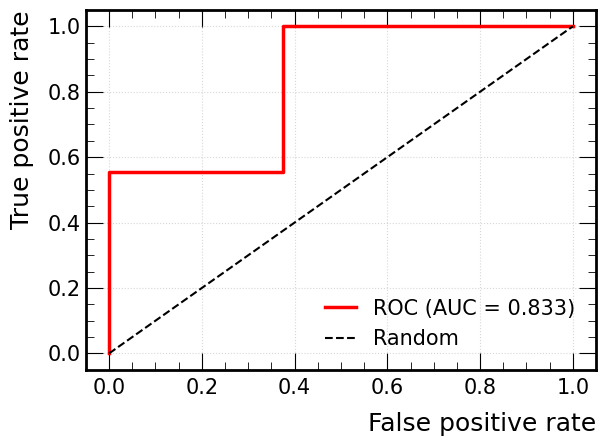

✅ Wrote ../images/lr-loocv-sel/feature_importance.png


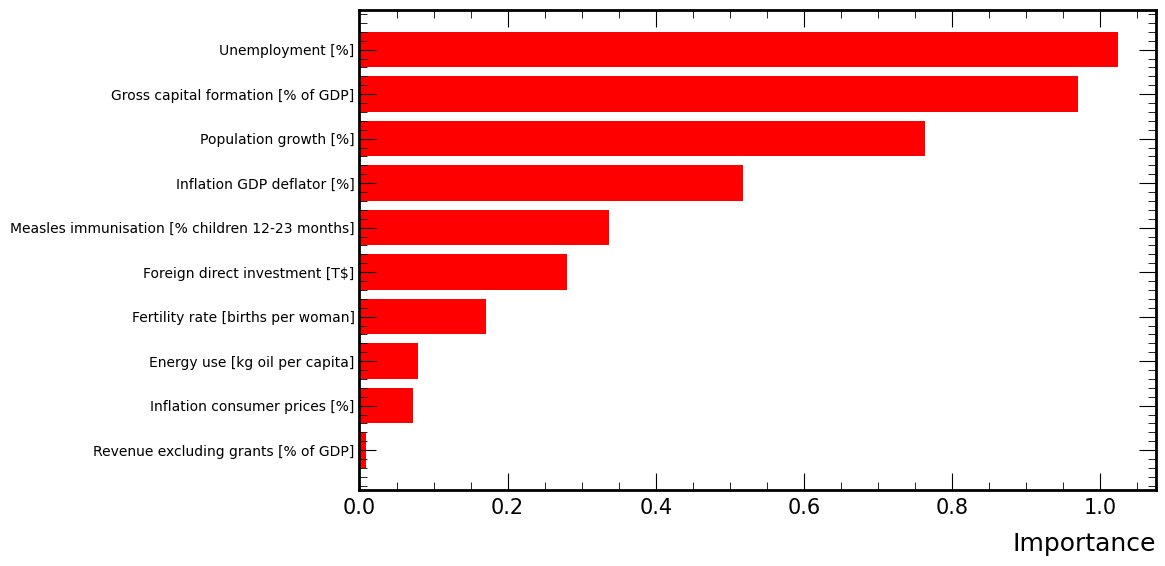

,Feature,Importance
9,Unemployment [%],1.024150
5,Gross capital formation [% of GDP],0.970689
0,Population growth [%],0.763920
4,Inflation GDP deflator [%],0.518337
2,Measles immunisation [% children 12-23 months],0.336695
7,Foreign direct investment [T$],0.279866
1,Fertility rate [births per woman],0.170632
3,Energy use [kg oil per capita],0.078989
8,Inflation consumer prices [%],0.071932
6,Revenue excluding grants [% of GDP],0.008342


In [19]:

selected_features = new_feature_names
# Training with selected features
trainer = Train(X=X[selected_features], y=y, model=LogisticRegression)

tag = "lr-loocv-sel"
results[tag] = trainer.train(
    loocv=True,
    random_state=42,
    tag = tag, 
)
metrics[tag] = Analyse(results[tag]).execute(X=X[selected_features], save_output=True) 

This is big improvement in AUC! I guess it filters out some of the noise and lets the model calibrate probabilties better

🚀 Training model: RandomForestClassifier
  Tag: rf-loocv-sel
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: False
  hyperparams: {}

✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,5,3
True 1,3,6



⭐ Classification report:



,precision,recall,f1-score,support
0,0.625000,0.625000,0.625000,8.000000
1,0.666667,0.666667,0.666667,9.000000
accuracy,0.647059,0.647059,0.647059,0.647059
macro avg,0.645833,0.645833,0.645833,17.000000
weighted avg,0.647059,0.647059,0.647059,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/rf-loocv-sel/roc_curve.png


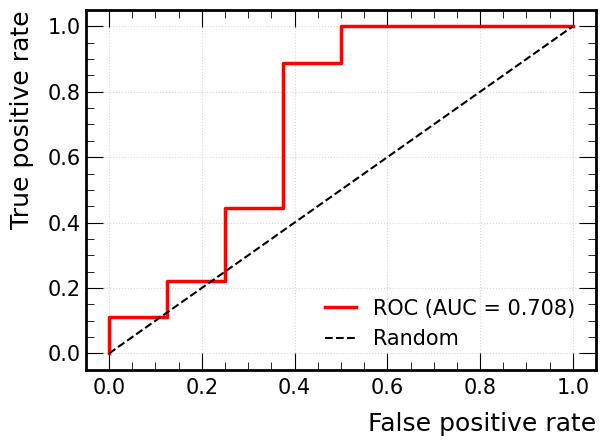

✅ Wrote ../images/rf-loocv-sel/feature_importance.png


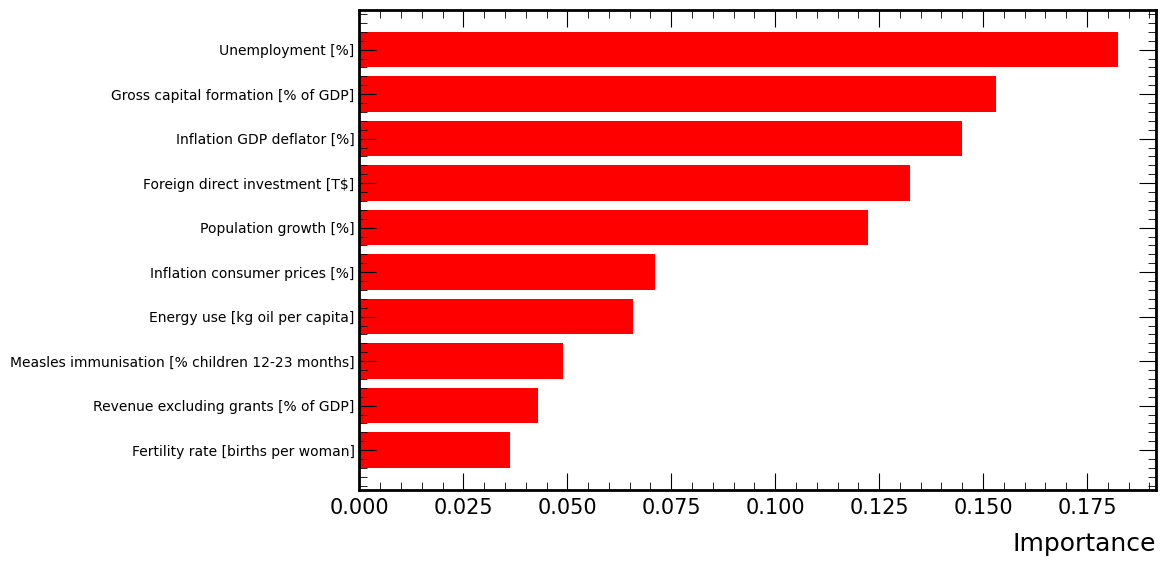

,Feature,Importance
9,Unemployment [%],0.182484
5,Gross capital formation [% of GDP],0.153054
4,Inflation GDP deflator [%],0.144839
7,Foreign direct investment [T$],0.132376
0,Population growth [%],0.122250
8,Inflation consumer prices [%],0.071071
3,Energy use [kg oil per capita],0.065873
2,Measles immunisation [% children 12-23 months],0.048837
6,Revenue excluding grants [% of GDP],0.042905
1,Fertility rate [births per woman],0.036311


In [20]:
# Training with selected features
trainer = Train(X=X[selected_features], y=y, model=RandomForestClassifier)

tag = "rf-loocv-sel"
results[tag] = trainer.train(
    loocv=True,
    random_state=42,
    tag = tag, 
)
metrics[tag] = Analyse(results[tag]).execute(X=X[selected_features], save_output=True) 

🚀 Training model: SVC
  Tag: svc-loocv-sel
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: True
  hyperparams: {'probability': True, 'kernel': 'linear'}

✅ Training complete.

✅ Results saved to ../results/svc-loocv-sel/results.pkl
⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,6,2
True 1,4,5



⭐ Classification report:



,precision,recall,f1-score,support
0,0.600000,0.750000,0.666667,8.000000
1,0.714286,0.555556,0.625000,9.000000
accuracy,0.647059,0.647059,0.647059,0.647059
macro avg,0.657143,0.652778,0.645833,17.000000
weighted avg,0.660504,0.647059,0.644608,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/svc-loocv-sel/roc_curve.png


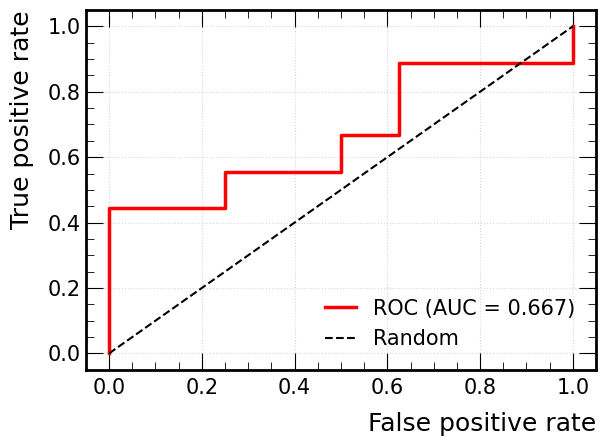

✅ Wrote ../images/svc-loocv-sel/feature_importance.png


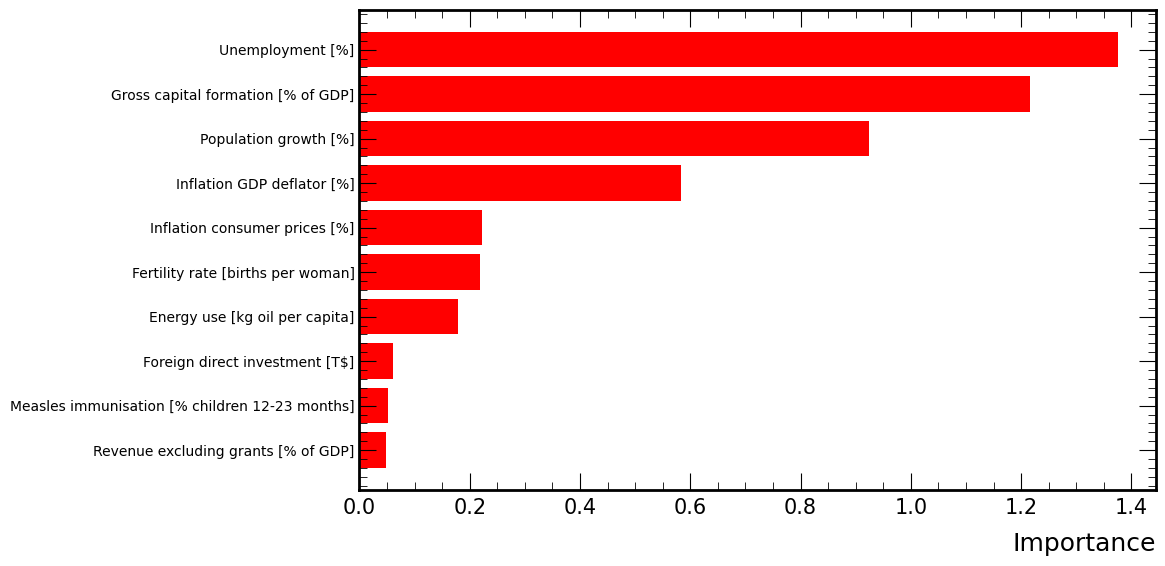

,Feature,Importance
9,Unemployment [%],1.375942
5,Gross capital formation [% of GDP],1.216312
0,Population growth [%],0.924464
4,Inflation GDP deflator [%],0.583551
8,Inflation consumer prices [%],0.222739
1,Fertility rate [births per woman],0.219013
3,Energy use [kg oil per capita],0.179513
7,Foreign direct investment [T$],0.061053
2,Measles immunisation [% children 12-23 months],0.051970
6,Revenue excluding grants [% of GDP],0.048937


In [21]:
trainer = Train(X=X[selected_features], y=y, model=SVC)
tag = "svc-loocv-sel"
results[tag] = trainer.train(
    loocv=True,
    random_state=42,
    tag = tag,
    probability=True,
    kernel="linear",
    save_output=True

)
# Analysis
metrics[tag] = Analyse(results[tag]).execute(X=X[selected_features], save_output=True)

🚀 Training model: XGBClassifier
  Tag: xgb-loocv-sel
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: True
  hyperparams: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

✅ Training complete.

✅ Results saved to ../results/xgb-loocv-sel/results.pkl
⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,4,4
True 1,3,6



⭐ Classification report:



,precision,recall,f1-score,support
0,0.571429,0.500000,0.533333,8.000000
1,0.600000,0.666667,0.631579,9.000000
accuracy,0.588235,0.588235,0.588235,0.588235
macro avg,0.585714,0.583333,0.582456,17.000000
weighted avg,0.586555,0.588235,0.585346,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/xgb-loocv-sel/roc_curve.png


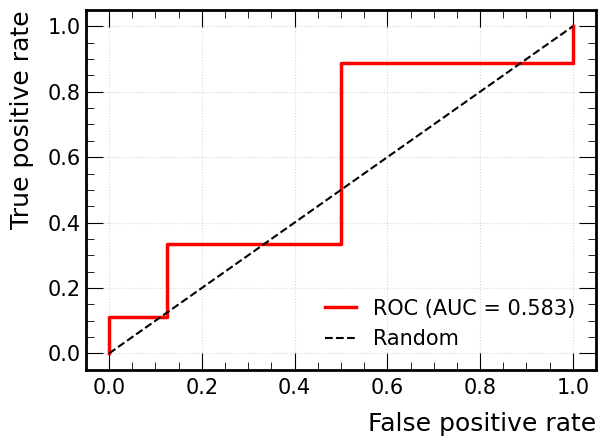

✅ Wrote ../images/xgb-loocv-sel/feature_importance.png


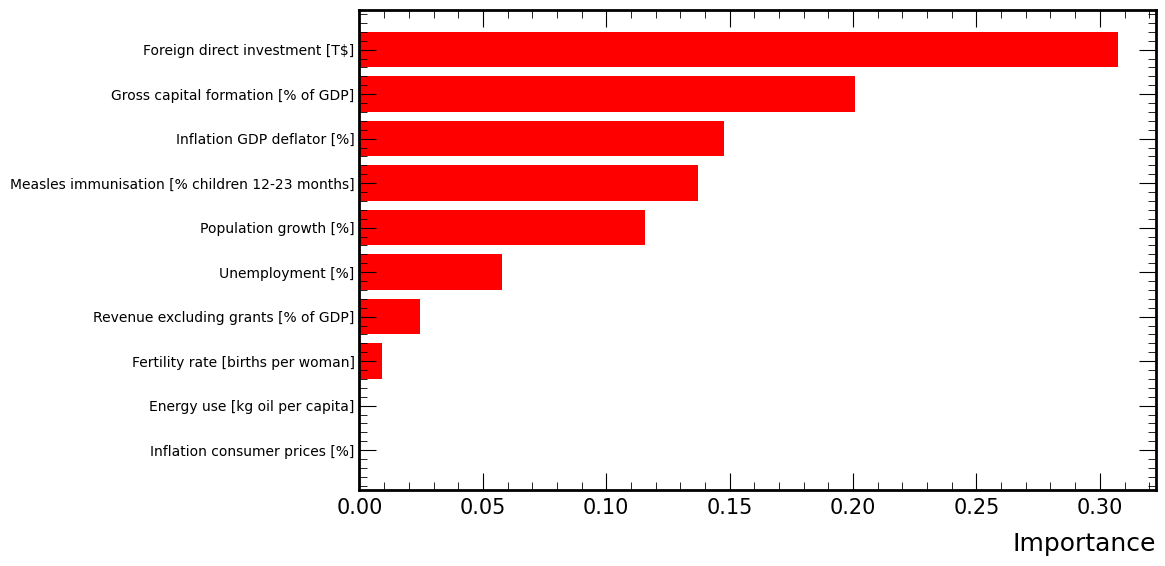

,Feature,Importance
7,Foreign direct investment [T$],0.307380
5,Gross capital formation [% of GDP],0.200624
4,Inflation GDP deflator [%],0.147751
2,Measles immunisation [% children 12-23 months],0.137053
0,Population growth [%],0.115700
9,Unemployment [%],0.057727
6,Revenue excluding grants [% of GDP],0.024693
1,Fertility rate [births per woman],0.009072
3,Energy use [kg oil per capita],0.000000
8,Inflation consumer prices [%],0.000000


In [22]:
trainer = Train(X=X[selected_features], y=y, model=XGBClassifier)
tag = "xgb-loocv-sel"
results[tag] = trainer.train(
    loocv=True,
    random_state=42,
    tag=tag,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    save_output=True
)
# Analysis
metrics[tag] = Analyse(results[tag]).execute(X=X[selected_features], save_output=True) 

##  Now try interaction terms

In [23]:
from sklearn.preprocessing import PolynomialFeatures

# Start with the 10 selected features for cleaner interaction terms
# Create interaction terms (degree=2 is products of pairs, no polynomials)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X[selected_features])

# Get feature names and format with multiplication operator
interaction_feature_names_raw = poly.get_feature_names_out(selected_features)
interaction_feature_names = [name.replace("] ", r"] $\times$ ") for name in interaction_feature_names_raw]

print(f"Original features: {len(selected_features)}")
print(f"With interactions: {len(interaction_feature_names)}")

# Create DataFrame with interaction features
X_interact = pd.DataFrame(X_interactions, columns=interaction_feature_names, index=X.index)

# Display a few interaction terms
print(f"\nSample interaction features:")
print(interaction_feature_names[10:20])

# Select best features from interactions (including base features)
selector_interact = SelectKBest(score_func=f_classif, k=15)
X_interact_selected = selector_interact.fit_transform(X_interact, y)

# Get selected feature names
selected_interact_features = X_interact.columns[selector_interact.get_support()]
print(f"Selected {len(selected_interact_features)} features from {len(X_interact.columns)} total")
print("\nSelected features (base and interactions):")
for feature in selected_interact_features:
    print(f"  {feature}")

X_interact = X_interact[selected_interact_features]

Original features: 10
With interactions: 55

Sample interaction features:
['Population growth [%] $\\times$ Fertility rate [births per woman]', 'Population growth [%] $\\times$ Measles immunisation [% children 12-23 months]', 'Population growth [%] $\\times$ Energy use [kg oil per capita]', 'Population growth [%] $\\times$ Inflation GDP deflator [%]', 'Population growth [%] $\\times$ Gross capital formation [% of GDP]', 'Population growth [%] $\\times$ Revenue excluding grants [% of GDP]', 'Population growth [%] $\\times$ Foreign direct investment [T$]', 'Population growth [%] $\\times$ Inflation consumer prices [%]', 'Population growth [%] $\\times$ Unemployment [%]', 'Fertility rate [births per woman] $\\times$ Measles immunisation [% children 12-23 months]']
Selected 15 features from 55 total

Selected features (base and interactions):
  Population growth [%]
  Inflation GDP deflator [%]
  Gross capital formation [% of GDP]
  Unemployment [%]
  Population growth [%] $\times$ Fertili

🚀 Training model: LogisticRegression
  Tag: lr-loocv-interact
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: False
  hyperparams: {}

✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,6,2
True 1,1,8



⭐ Classification report:



,precision,recall,f1-score,support
0,0.857143,0.750000,0.800000,8.000000
1,0.800000,0.888889,0.842105,9.000000
accuracy,0.823529,0.823529,0.823529,0.823529
macro avg,0.828571,0.819444,0.821053,17.000000
weighted avg,0.826891,0.823529,0.822291,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/lr-loocv-interact/roc_curve.png


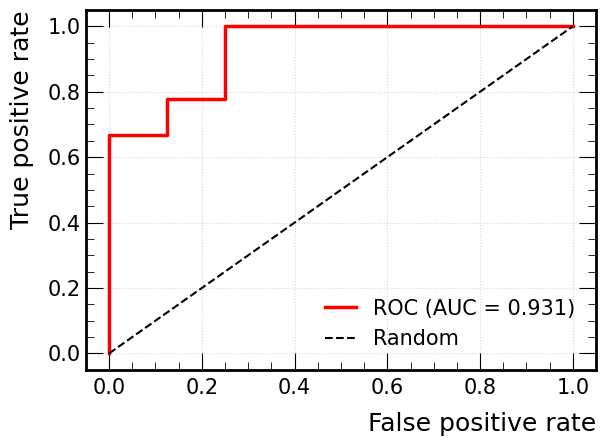

✅ Wrote ../images/lr-loocv-interact/feature_importance.png


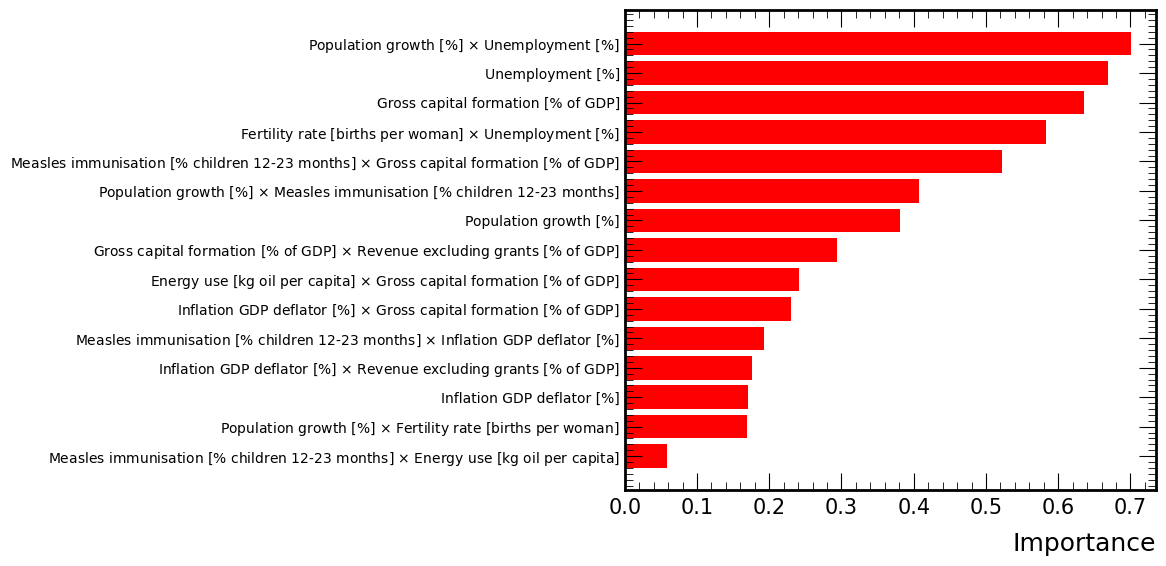

,Feature,Importance
6,Population growth [%] $\times$ Unemployment [%],0.700425
3,Unemployment [%],0.668870
2,Gross capital formation [% of GDP],0.635553
7,Fertility rate [births per woman] $\times$ Une...,0.582799
10,Measles immunisation [% children 12-23 months]...,0.522254
5,Population growth [%] $\times$ Measles immunis...,0.407025
0,Population growth [%],0.380547
14,Gross capital formation [% of GDP] $\times$ Re...,0.294451
11,Energy use [kg oil per capita] $\times$ Gross ...,0.240529
12,Inflation GDP deflator [%] $\times$ Gross capi...,0.229815


In [24]:
trainer = Train(X=X_interact, y=y, model=LogisticRegression)

tag = "lr-loocv-interact"
results[tag] = trainer.train(
    loocv=True,
    random_state=42,
    tag=tag,
)
metrics[tag] = Analyse(results[tag]).execute(X=X_interact, save_output=True)

🚀 Training model: RandomForestClassifier
  Tag: rf-loocv-sel-interact
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: False
  hyperparams: {}

✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,7,1
True 1,1,8



⭐ Classification report:



,precision,recall,f1-score,support
0,0.875000,0.875000,0.875000,8.000000
1,0.888889,0.888889,0.888889,9.000000
accuracy,0.882353,0.882353,0.882353,0.882353
macro avg,0.881944,0.881944,0.881944,17.000000
weighted avg,0.882353,0.882353,0.882353,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/rf-loocv-sel-interact/roc_curve.png


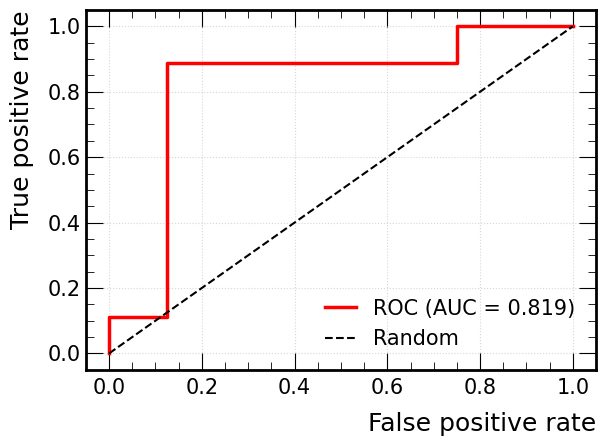

✅ Wrote ../images/rf-loocv-sel-interact/feature_importance.png


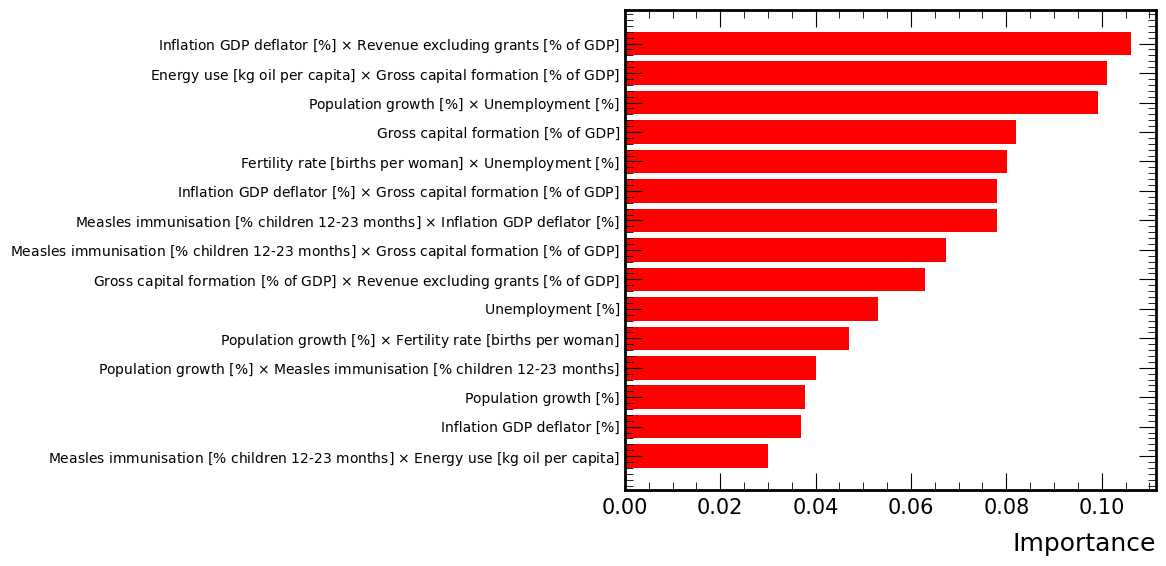

,Feature,Importance
13,Inflation GDP deflator [%] $\times$ Revenue ex...,0.106085
11,Energy use [kg oil per capita] $\times$ Gross ...,0.101096
6,Population growth [%] $\times$ Unemployment [%],0.099280
2,Gross capital formation [% of GDP],0.082048
7,Fertility rate [births per woman] $\times$ Une...,0.080079
12,Inflation GDP deflator [%] $\times$ Gross capi...,0.078145
9,Measles immunisation [% children 12-23 months]...,0.078139
10,Measles immunisation [% children 12-23 months]...,0.067304
14,Gross capital formation [% of GDP] $\times$ Re...,0.062937
3,Unemployment [%],0.053092


In [25]:
# Train Random Forest with interaction features
trainer = Train(X=X_interact, y=y, model=RandomForestClassifier)

tag = "rf-loocv-sel-interact"
results[tag] = trainer.train(
    loocv=True,
    random_state=42,
    tag=tag,
)
metrics[tag] = Analyse(results[tag]).execute(X=X_interact, save_output=True)

🚀 Training model: SVC
  Tag: svc-loocv-sel-interact
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: True
  hyperparams: {'probability': True, 'kernel': 'linear'}

✅ Training complete.

✅ Results saved to ../results/svc-loocv-sel-interact/results.pkl
⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,7,1
True 1,1,8



⭐ Classification report:



,precision,recall,f1-score,support
0,0.875000,0.875000,0.875000,8.000000
1,0.888889,0.888889,0.888889,9.000000
accuracy,0.882353,0.882353,0.882353,0.882353
macro avg,0.881944,0.881944,0.881944,17.000000
weighted avg,0.882353,0.882353,0.882353,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/svc-loocv-sel-interact/roc_curve.png


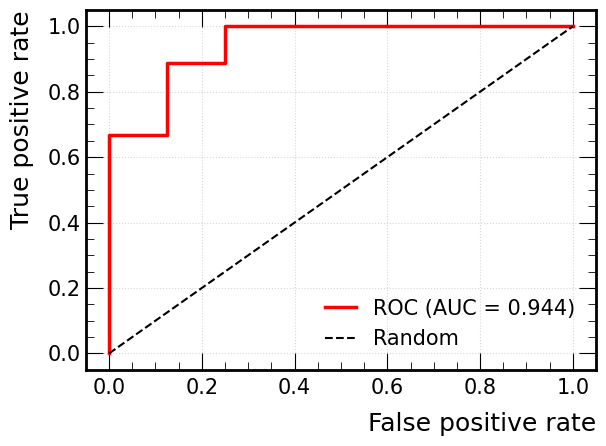

✅ Wrote ../images/svc-loocv-sel-interact/feature_importance.png


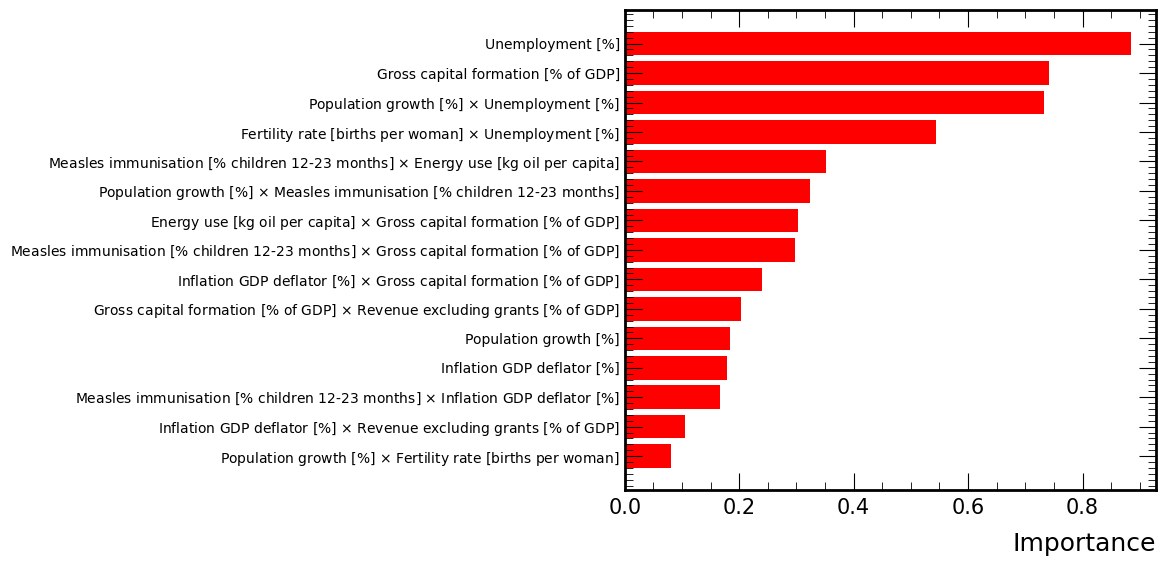

,Feature,Importance
3,Unemployment [%],0.884241
2,Gross capital formation [% of GDP],0.741442
6,Population growth [%] $\times$ Unemployment [%],0.732894
7,Fertility rate [births per woman] $\times$ Une...,0.543834
8,Measles immunisation [% children 12-23 months]...,0.351491
5,Population growth [%] $\times$ Measles immunis...,0.322923
11,Energy use [kg oil per capita] $\times$ Gross ...,0.302191
10,Measles immunisation [% children 12-23 months]...,0.298086
12,Inflation GDP deflator [%] $\times$ Gross capi...,0.239894
14,Gross capital formation [% of GDP] $\times$ Re...,0.202556


In [26]:
trainer = Train(X=X_interact, y=y, model=SVC)
tag = "svc-loocv-sel-interact"
results[tag] = trainer.train(
    loocv=True,
    random_state=42,
    tag = tag,
    probability=True,
    kernel="linear",
    save_output=True

)
# Analysis
metrics[tag] = Analyse(results[tag]).execute(X=X_interact, save_output=True)

🚀 Training model: XGBClassifier
  Tag: xgb-loocv-sel-interact
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: True
  hyperparams: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

✅ Training complete.

✅ Results saved to ../results/xgb-loocv-sel-interact/results.pkl
⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,5,3
True 1,3,6



⭐ Classification report:



,precision,recall,f1-score,support
0,0.625000,0.625000,0.625000,8.000000
1,0.666667,0.666667,0.666667,9.000000
accuracy,0.647059,0.647059,0.647059,0.647059
macro avg,0.645833,0.645833,0.645833,17.000000
weighted avg,0.647059,0.647059,0.647059,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/xgb-loocv-sel-interact/roc_curve.png


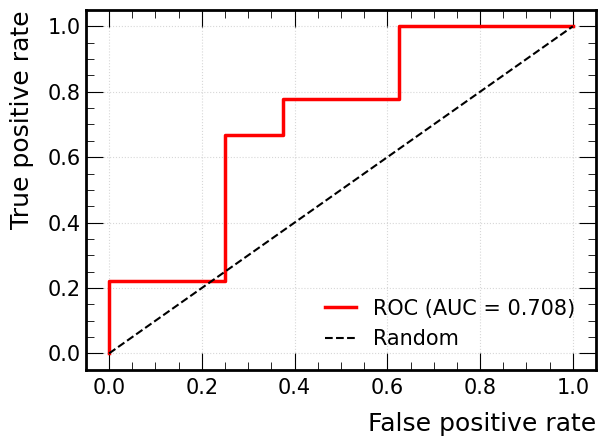

✅ Wrote ../images/xgb-loocv-sel-interact/feature_importance.png


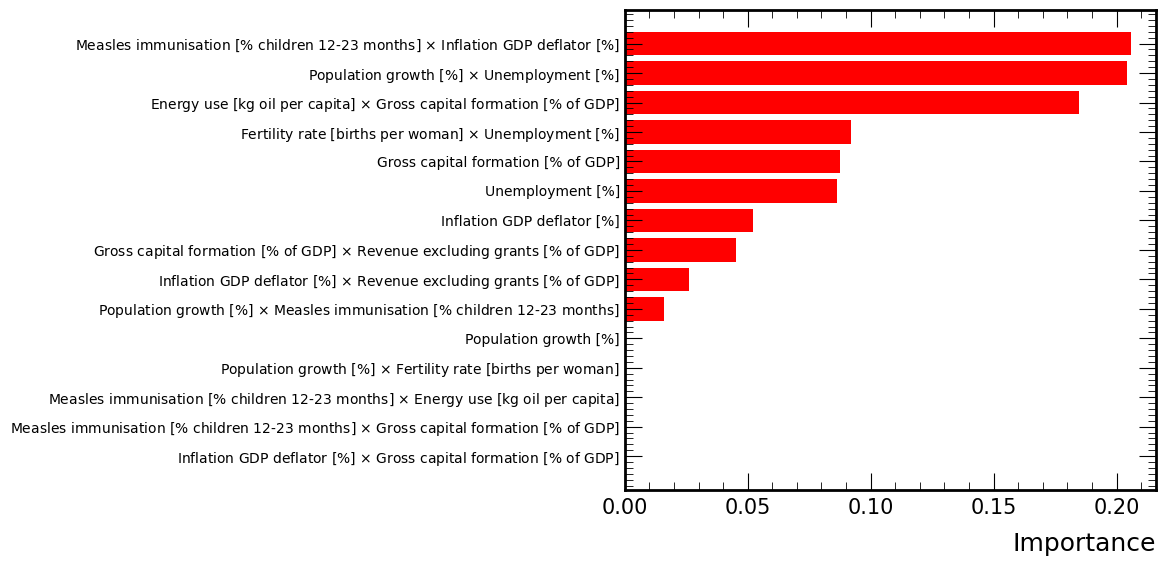

,Feature,Importance
9,Measles immunisation [% children 12-23 months]...,0.205778
6,Population growth [%] $\times$ Unemployment [%],0.204379
11,Energy use [kg oil per capita] $\times$ Gross ...,0.184790
7,Fertility rate [births per woman] $\times$ Une...,0.091961
2,Gross capital formation [% of GDP],0.087620
3,Unemployment [%],0.086308
1,Inflation GDP deflator [%],0.052051
14,Gross capital formation [% of GDP] $\times$ Re...,0.045048
13,Inflation GDP deflator [%] $\times$ Revenue ex...,0.026098
5,Population growth [%] $\times$ Measles immunis...,0.015967


In [27]:
trainer = Train(X=X_interact, y=y, model=XGBClassifier)
tag = "xgb-loocv-sel-interact"
results[tag] = trainer.train(
    loocv=True,
    random_state=42,
    tag=tag,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    save_output=True
)
# Analysis
metrics[tag] = Analyse(results[tag]).execute(X=X_interact, save_output=True) 

## Compare performance again

✅ Wrote ../images/metrics_comparison.png


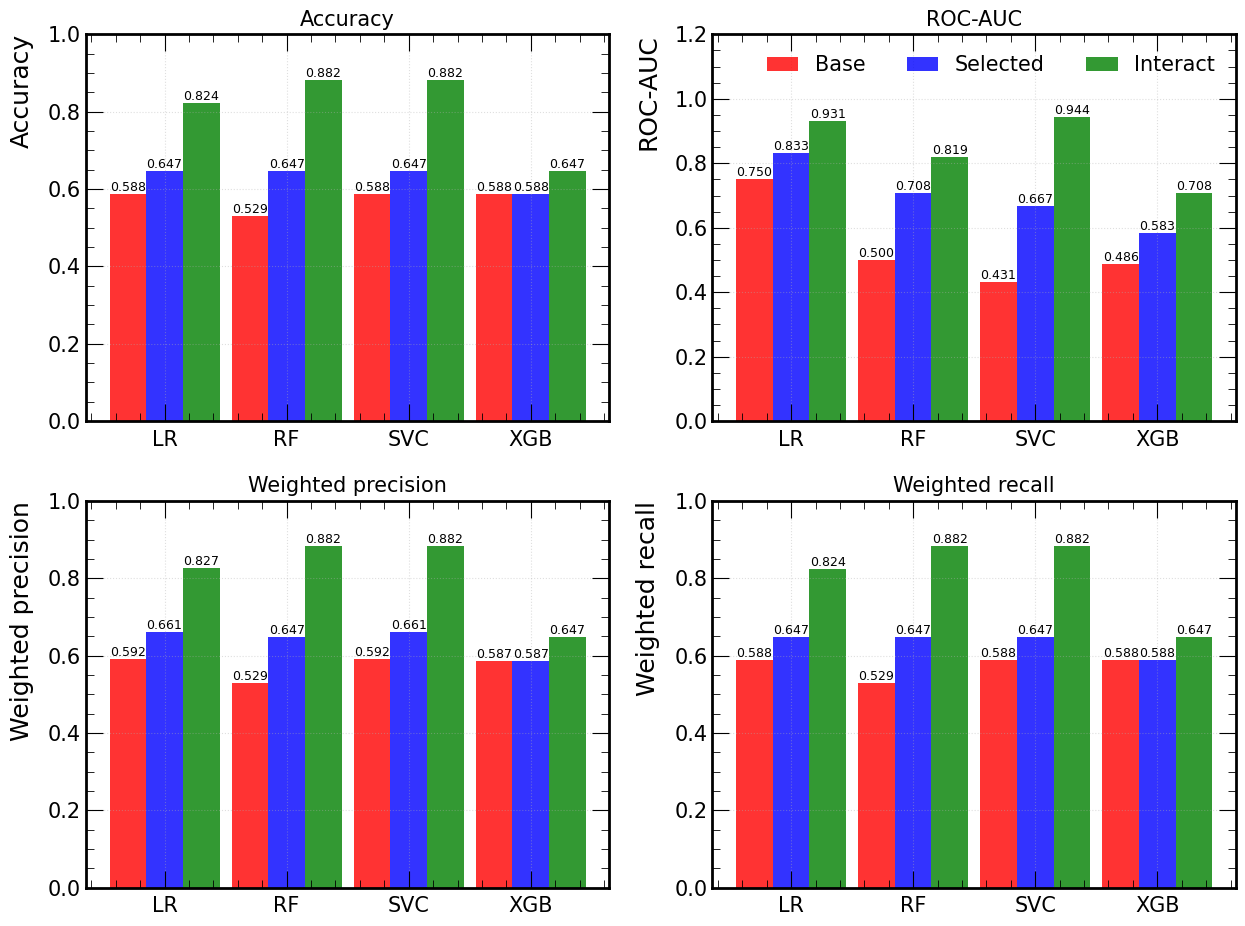

In [28]:
# Compare all model variants: base, selected features, and selected+interactions
import numpy as np

# Define model groups and their tags
model_groups = [
    ("LR", ["lr-loocv", "lr-loocv-sel", "lr-loocv-interact"]),
    ("RF", ["rf-loocv", "rf-loocv-sel", "rf-loocv-sel-interact"]),
    ("SVC", ["svc-loocv", "svc-loocv-sel", "svc-loocv-sel-interact"]),
    ("XGB", ["xgb-loocv", "xgb-loocv-sel", "xgb-loocv-sel-interact"]),
]

variant_labels = ["Base", "Selected", "Interact"]

# Prepare data
acc, auc, precision, recall = [], [], [], []
for _, tags in model_groups:
    acc_row, auc_row, prec_row, rec_row = [], [], [], []
    for tag in tags:
        m = metrics.get(tag)
        if m is not None:
            report = m["report"]
            acc_row.append(report.loc["accuracy", "precision"])
            auc_row.append(m["roc"]["auc"])
            prec_row.append(report.loc["weighted avg", "precision"])
            rec_row.append(report.loc["weighted avg", "recall"])
        else:
            acc_row.append(np.nan)
            auc_row.append(np.nan)
            prec_row.append(np.nan)
            rec_row.append(np.nan)
    acc.append(acc_row)
    auc.append(auc_row)
    precision.append(prec_row)
    recall.append(rec_row)

acc = np.array(acc)
auc = np.array(auc)
precision = np.array(precision)
recall = np.array(recall)

# Plot grouped bars
fig, ax = plt.subplots(2, 2, figsize=(2*6.4, 2*4.8))
bar_width = 0.30
x = np.arange(len(model_groups))

for i, (metric, data, title) in enumerate([
    (acc, acc, "Accuracy"),
    (auc, auc, "ROC-AUC"),
    (precision, precision, "Weighted precision"),
    (recall, recall, "Weighted recall"),
]):
    row, col = divmod(i, 2)
    for j in range(len(variant_labels)):
        bars = ax[row, col].bar(
            x + bar_width * j - bar_width,  
            data[:, j],
            width=bar_width,
            label=variant_labels[j],
            alpha=0.8
        )
        for bar in bars:
            height = bar.get_height()
            if not np.isnan(height):
                ax[row, col].text(
                    bar.get_x() + bar.get_width() / 2., height,
                    f"{height:.3f}", ha="center", va="bottom", fontsize=9,
                )
    ax[row, col].set_xticks(x)
    ax[row, col].set_xticklabels([g[0] for g in model_groups])
    ax[row, col].set_ylim([0, 1])
    ax[row, col].set_ylabel(title)
    ax[row, col].set_title(title)
    ax[row, col].grid(alpha=0.4)
    if row == 0 and col == 1:
        ax[row, col].set_ylim(0, 1.20)
        ax[row, col].legend(ncols=3, loc="upper right")

plt.tight_layout()
file_name = "../images/metrics_comparison.png"
plt.savefig(file_name)
print(f"✅ Wrote {file_name}")
plt.show()

## Hyperparameter tuning

In [29]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X_tune = X_interact.copy()

# Dictionary to store tuning_results
tuning_results = {}

# ============================================================================
# 1. LOGISTIC REGRESSION (needs scaling)
# ============================================================================
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

param_grid_lr = {
    "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "classifier__penalty": ["l1", "l2"],
    "classifier__solver": ["liblinear", "saga"],
    "classifier__max_iter": [5000]
}

grid_search_lr = GridSearchCV(
    pipeline_lr,
    param_grid_lr,
    cv=LeaveOneOut(),
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
print("Running Logistic Regression grid search...")
grid_search_lr.fit(X_tune, y)  # Use UNSCALED data - pipeline handles scaling
tuning_results['Logistic Regression'] = {
    'best_params': grid_search_lr.best_params_,
    'best_score': grid_search_lr.best_score_
}

# ============================================================================
# 2. RANDOM FOREST (no scaling needed)
# ============================================================================
param_grid_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 4, 5, 6],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3],
    "max_features": ["sqrt", "log2"],
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=LeaveOneOut(),
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
print("\nRunning Random Forest grid search...")
grid_search_rf.fit(X_tune, y)
tuning_results['Random Forest'] = {
    'best_params': grid_search_rf.best_params_,
    'best_score': grid_search_rf.best_score_
}

# ============================================================================
# 3. SVC (needs scaling)
# ============================================================================
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=42))
])

param_grid_svc = {
    "classifier__C": [0.1, 1, 10, 100],
    "classifier__kernel": ["linear", "rbf", "poly"],
    "classifier__gamma": ["scale", "auto", 0.001, 0.01, 0.1],
    "classifier__degree": [2, 3, 4]
}

grid_search_svc = GridSearchCV(
    pipeline_svc,
    param_grid_svc,
    cv=LeaveOneOut(),
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
print("\nRunning SVC grid search...")
grid_search_svc.fit(X_tune, y)  # Use UNSCALED data - pipeline handles scaling
tuning_results['SVC'] = {
    'best_params': grid_search_svc.best_params_,
    'best_score': grid_search_svc.best_score_
}

# ============================================================================
# 4. XGBOOST (no scaling needed)
# ============================================================================
param_grid_xgb = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5]
}

# Convert to numpy array to avoid feature name issues
X_tune_array = X_tune.values if hasattr(X_tune, 'values') else X_tune

grid_search_xgb = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid_xgb,
    cv=LeaveOneOut(),
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
print("\nRunning XGBoost grid search...")
grid_search_xgb.fit(X_tune_array, y)
tuning_results['XGBoost'] = {
    'best_params': grid_search_xgb.best_params_,
    'best_score': grid_search_xgb.best_score_
}

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*70)
print("SUMMARY OF ALL MODELS")
print("="*70)
for model_name, result in tuning_results.items():
    print(f"\n{model_name}:")
    print(f"  Best parameters: {result['best_params']}")
    print(f"  Best CV accuracy: {result['best_score']:.3f}")

Running Logistic Regression grid search...
Fitting 17 folds for each of 24 candidates, totalling 408 fits

Running Random Forest grid search...
Fitting 17 folds for each of 216 candidates, totalling 3672 fits

Running SVC grid search...
Fitting 17 folds for each of 180 candidates, totalling 3060 fits

Running XGBoost grid search...
Fitting 17 folds for each of 1296 candidates, totalling 22032 fits

SUMMARY OF ALL MODELS

Logistic Regression:
  Best parameters: {'classifier__C': 0.001, 'classifier__max_iter': 5000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
  Best CV accuracy: 0.882

Random Forest:
  Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  Best CV accuracy: 0.882

SVC:
  Best parameters: {'classifier__C': 1, 'classifier__degree': 2, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
  Best CV accuracy: 0.882

XGBoost:
  Best parameters: {'colsample_bytree': 0.6, 'learn

In [30]:
print("\nHyperparameter tuning results:")
for model_name, result in tuning_results.items():
    print(f"\n{model_name}:")
    print(f"Best parameters: {result['best_params']}")
    print(f"Best LOOCV Accuracy: {result['best_score']:.3f}")


Hyperparameter tuning results:

Logistic Regression:
Best parameters: {'classifier__C': 0.001, 'classifier__max_iter': 5000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best LOOCV Accuracy: 0.882

Random Forest:
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best LOOCV Accuracy: 0.882

SVC:
Best parameters: {'classifier__C': 1, 'classifier__degree': 2, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best LOOCV Accuracy: 0.882

XGBoost:
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.6}
Best LOOCV Accuracy: 0.824


Train everything again, a bit ugly but whatever

🚀 Training model: LogisticRegression
  Tag: lr-loocv-sel-inter-tuned
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: True
  hyperparams: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 5000}

✅ Training complete.

✅ Results saved to ../results/lr-loocv-sel-inter-tuned/results.pkl
⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,7,1
True 1,1,8



⭐ Classification report:



,precision,recall,f1-score,support
0,0.875000,0.875000,0.875000,8.000000
1,0.888889,0.888889,0.888889,9.000000
accuracy,0.882353,0.882353,0.882353,0.882353
macro avg,0.881944,0.881944,0.881944,17.000000
weighted avg,0.882353,0.882353,0.882353,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/lr-loocv-sel-inter-tuned/roc_curve.png


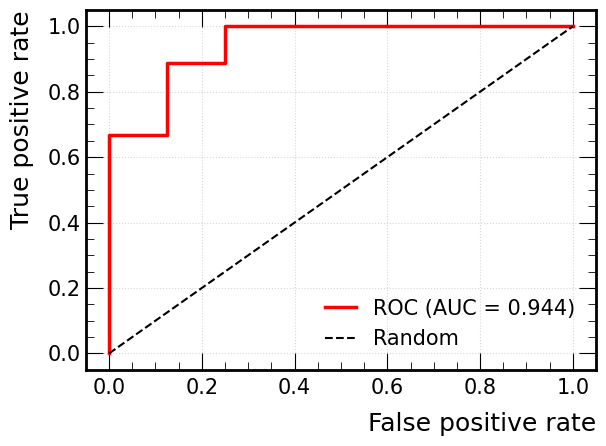

✅ Wrote ../images/lr-loocv-sel-inter-tuned/feature_importance.png


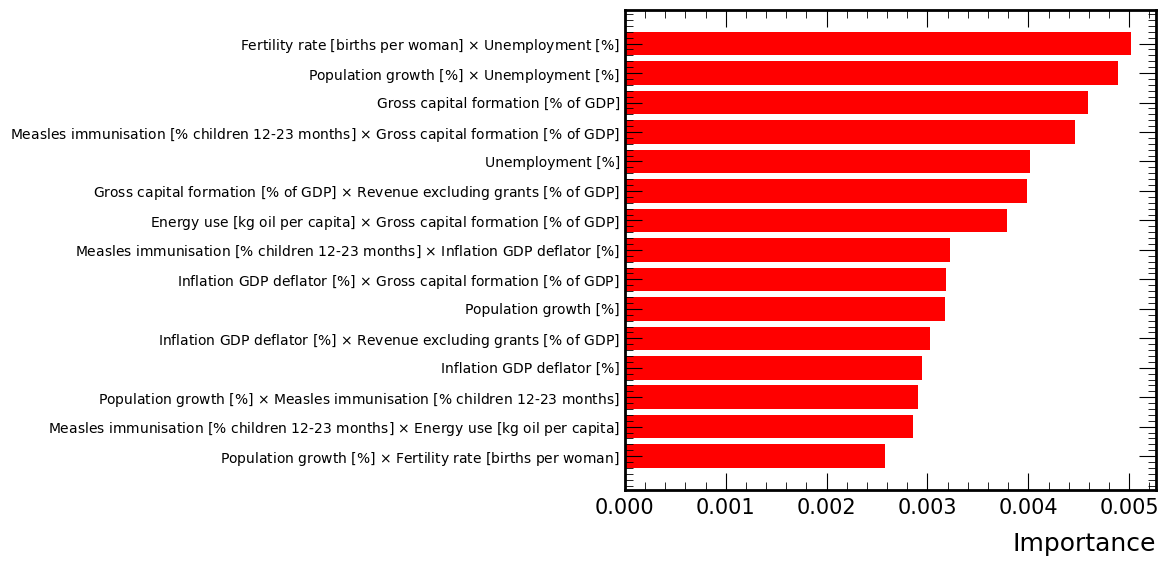

,Feature,Importance
7,Fertility rate [births per woman] $\times$ Une...,0.005014
6,Population growth [%] $\times$ Unemployment [%],0.004886
2,Gross capital formation [% of GDP],0.004595
10,Measles immunisation [% children 12-23 months]...,0.004460
3,Unemployment [%],0.004013
14,Gross capital formation [% of GDP] $\times$ Re...,0.003989
11,Energy use [kg oil per capita] $\times$ Gross ...,0.003791
9,Measles immunisation [% children 12-23 months]...,0.003218
12,Inflation GDP deflator [%] $\times$ Gross capi...,0.003187
0,Population growth [%],0.003173


In [31]:
trainer = Train(X=X_tune, y=y, model=LogisticRegression)
tag = "lr-loocv-sel-inter-tuned"
results[tag] = trainer.train(
    loocv=True,
    random_state=42,
    tag = tag, 
    save_output=True,
    C=grid_search_lr.best_params_['classifier__C'],
    penalty=grid_search_lr.best_params_['classifier__penalty'],
    solver=grid_search_lr.best_params_['classifier__solver'],
    max_iter=grid_search_lr.best_params_['classifier__max_iter'],
)
metrics[tag] = Analyse(results[tag]).execute(X=X_tune, save_output=True) 

🚀 Training model: RandomForestClassifier
  Tag: rf-loocv-sel-inter-tuned
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: True
  hyperparams: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1}

✅ Training complete.

✅ Results saved to ../results/rf-loocv-sel-inter-tuned/results.pkl
⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,7,1
True 1,1,8



⭐ Classification report:



,precision,recall,f1-score,support
0,0.875000,0.875000,0.875000,8.000000
1,0.888889,0.888889,0.888889,9.000000
accuracy,0.882353,0.882353,0.882353,0.882353
macro avg,0.881944,0.881944,0.881944,17.000000
weighted avg,0.882353,0.882353,0.882353,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/rf-loocv-sel-inter-tuned/roc_curve.png


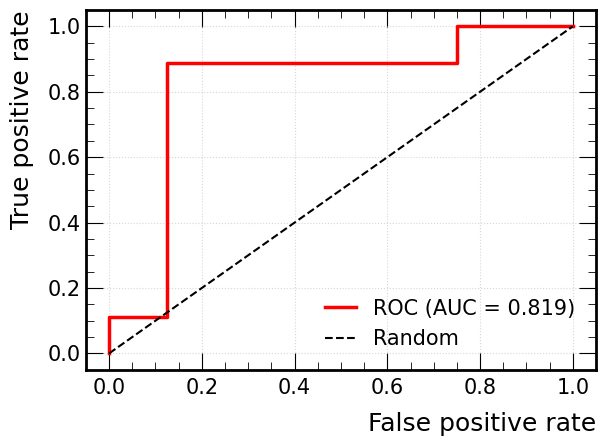

✅ Wrote ../images/rf-loocv-sel-inter-tuned/feature_importance.png


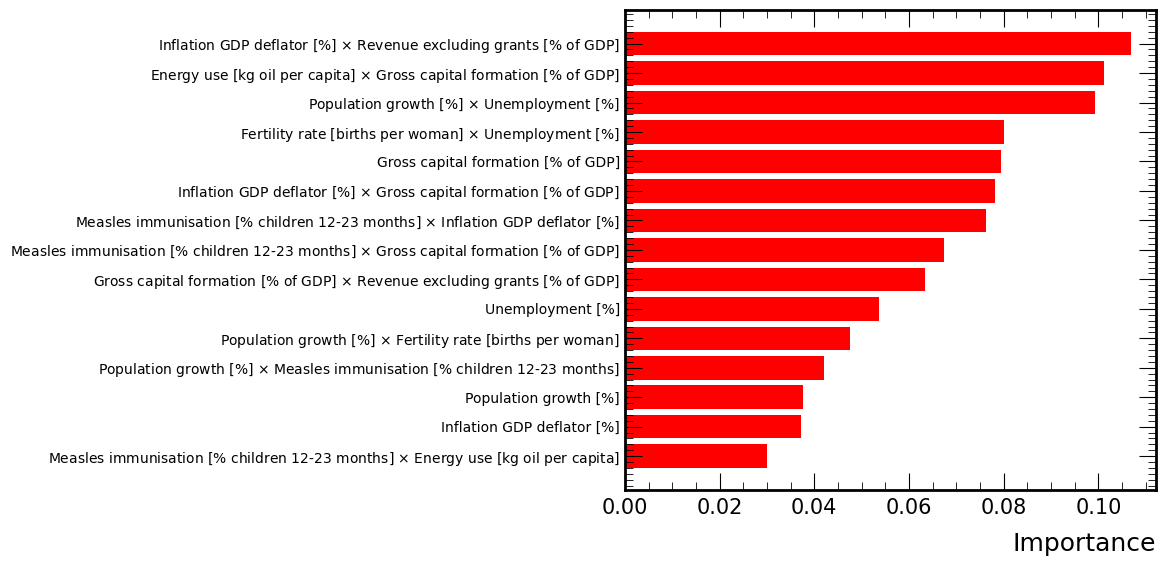

,Feature,Importance
13,Inflation GDP deflator [%] $\times$ Revenue ex...,0.106812
11,Energy use [kg oil per capita] $\times$ Gross ...,0.101096
6,Population growth [%] $\times$ Unemployment [%],0.099280
7,Fertility rate [births per woman] $\times$ Une...,0.080079
2,Gross capital formation [% of GDP],0.079528
12,Inflation GDP deflator [%] $\times$ Gross capi...,0.078256
9,Measles immunisation [% children 12-23 months]...,0.076199
10,Measles immunisation [% children 12-23 months]...,0.067304
14,Gross capital formation [% of GDP] $\times$ Re...,0.063399
3,Unemployment [%],0.053635


In [32]:

trainer = Train(X=X_tune, y=y, model=RandomForestClassifier)
tag = "rf-loocv-sel-inter-tuned"
results[tag] = trainer.train(
    loocv=True,
    random_state=42,
    tag = tag, 
    save_output=True,
    max_depth=grid_search_rf.best_params_['max_depth'],
    max_features=grid_search_rf.best_params_['max_features'],
    n_estimators=grid_search_rf.best_params_['n_estimators'],
    min_samples_split=grid_search_rf.best_params_['min_samples_split'],
    min_samples_leaf=grid_search_rf.best_params_['min_samples_leaf'],
)
metrics[tag] = Analyse(results[tag]).execute(X=X_tune, save_output=True) 

🚀 Training model: SVC
  Tag: svc-loocv-sel-inter-tuned
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: True
  hyperparams: {'probability': True, 'kernel': 'linear', 'C': 1, 'gamma': 'scale', 'degree': 2}

✅ Training complete.

✅ Results saved to ../results/svc-loocv-sel-inter-tuned/results.pkl
⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,7,1
True 1,1,8



⭐ Classification report:



,precision,recall,f1-score,support
0,0.875000,0.875000,0.875000,8.000000
1,0.888889,0.888889,0.888889,9.000000
accuracy,0.882353,0.882353,0.882353,0.882353
macro avg,0.881944,0.881944,0.881944,17.000000
weighted avg,0.882353,0.882353,0.882353,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/svc-loocv-sel-inter-tuned/roc_curve.png


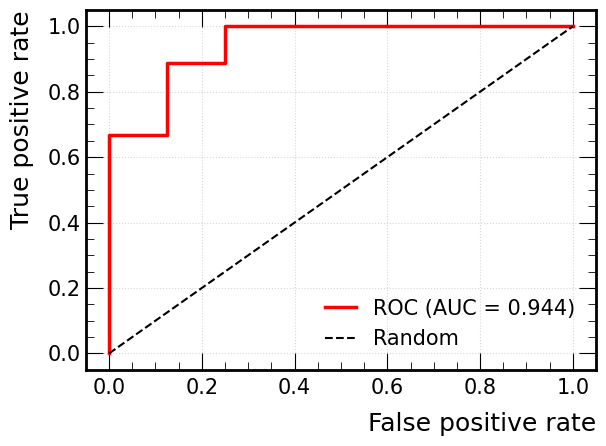

✅ Wrote ../images/svc-loocv-sel-inter-tuned/feature_importance.png


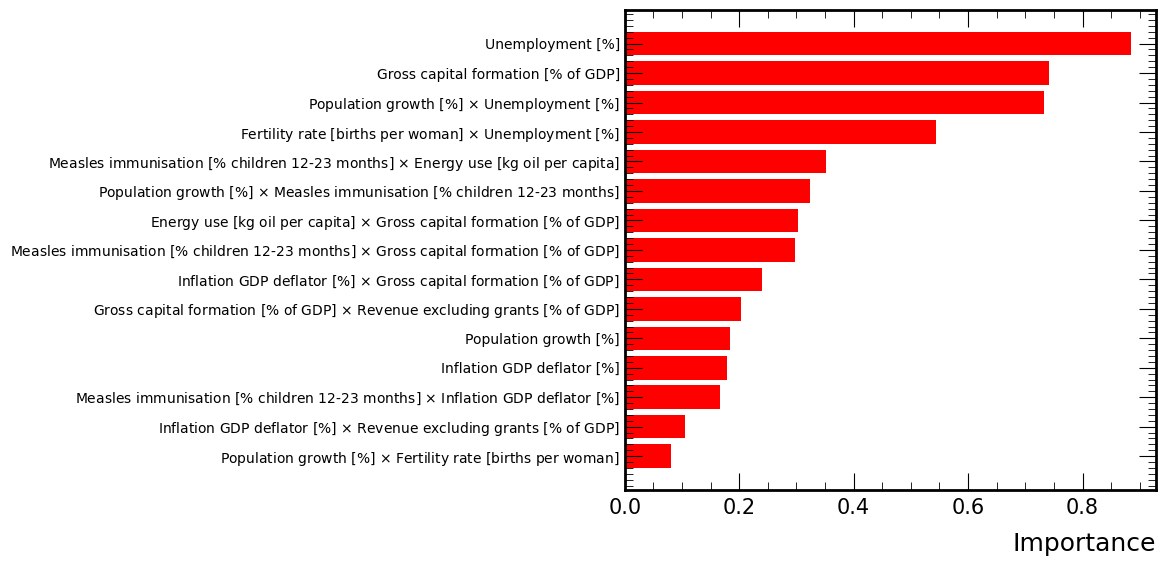

,Feature,Importance
3,Unemployment [%],0.884241
2,Gross capital formation [% of GDP],0.741442
6,Population growth [%] $\times$ Unemployment [%],0.732894
7,Fertility rate [births per woman] $\times$ Une...,0.543834
8,Measles immunisation [% children 12-23 months]...,0.351491
5,Population growth [%] $\times$ Measles immunis...,0.322923
11,Energy use [kg oil per capita] $\times$ Gross ...,0.302191
10,Measles immunisation [% children 12-23 months]...,0.298086
12,Inflation GDP deflator [%] $\times$ Gross capi...,0.239894
14,Gross capital formation [% of GDP] $\times$ Re...,0.202556


In [33]:

trainer = Train(X=X_tune, y=y, model=SVC)
tag = "svc-loocv-sel-inter-tuned"
results[tag] = trainer.train(
    loocv=True,
    random_state=42,
    tag = tag, 
    probability=True,
    save_output=True,
    kernel=grid_search_svc.best_params_['classifier__kernel'],
    C=grid_search_svc.best_params_['classifier__C'],
    gamma=grid_search_svc.best_params_['classifier__gamma'],
    degree=grid_search_svc.best_params_['classifier__degree'],
)
metrics[tag] = Analyse(results[tag]).execute(X=X_tune, save_output=True) 


🚀 Training model: XGBClassifier
  Tag: xgb-loocv-sel-inter-tuned
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: True
  hyperparams: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'min_child_weight': 1, 'subsample': 0.6}

✅ Training complete.

✅ Results saved to ../results/xgb-loocv-sel-inter-tuned/results.pkl
⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,6,2
True 1,1,8



⭐ Classification report:



,precision,recall,f1-score,support
0,0.857143,0.750000,0.800000,8.000000
1,0.800000,0.888889,0.842105,9.000000
accuracy,0.823529,0.823529,0.823529,0.823529
macro avg,0.828571,0.819444,0.821053,17.000000
weighted avg,0.826891,0.823529,0.822291,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/xgb-loocv-sel-inter-tuned/roc_curve.png


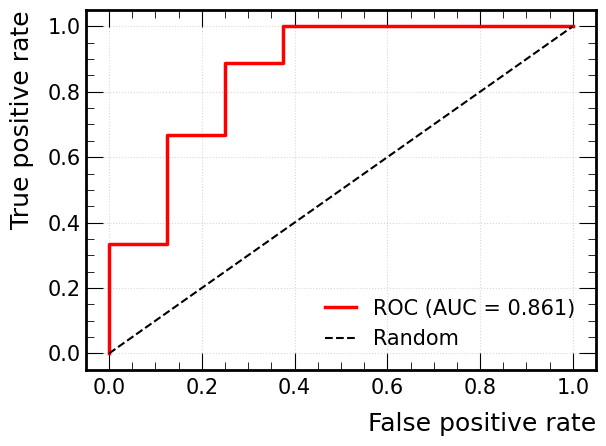

✅ Wrote ../images/xgb-loocv-sel-inter-tuned/feature_importance.png


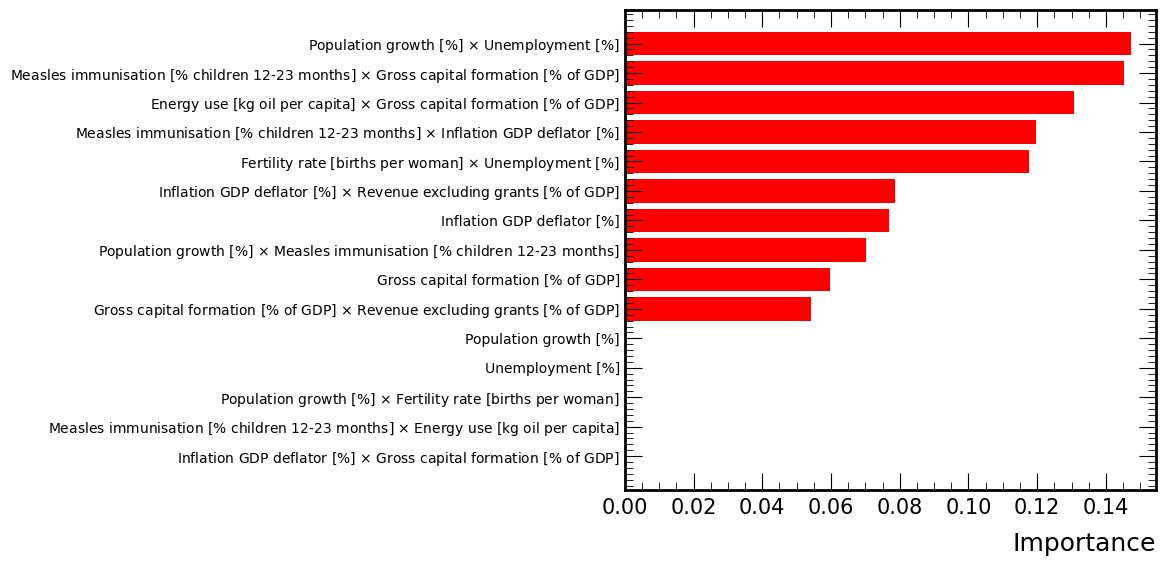

,Feature,Importance
6,Population growth [%] $\times$ Unemployment [%],0.147206
10,Measles immunisation [% children 12-23 months]...,0.145350
11,Energy use [kg oil per capita] $\times$ Gross ...,0.130826
9,Measles immunisation [% children 12-23 months]...,0.119554
7,Fertility rate [births per woman] $\times$ Une...,0.117617
13,Inflation GDP deflator [%] $\times$ Revenue ex...,0.078482
1,Inflation GDP deflator [%],0.076971
5,Population growth [%] $\times$ Measles immunis...,0.070251
2,Gross capital formation [% of GDP],0.059692
14,Gross capital formation [% of GDP] $\times$ Re...,0.054050


In [34]:
trainer = Train(X=X_tune, y=y, model=XGBClassifier)
tag = "xgb-loocv-sel-inter-tuned"
results[tag] = trainer.train(
    loocv=True,
    random_state=42,
    tag = tag, 
    n_estimators=grid_search_xgb.best_params_['n_estimators'],
    max_depth=grid_search_xgb.best_params_['max_depth'],
    learning_rate=grid_search_xgb.best_params_['learning_rate'],
    colsample_bytree=grid_search_xgb.best_params_['colsample_bytree'],
    min_child_weight=grid_search_xgb.best_params_['min_child_weight'],
    subsample=grid_search_xgb.best_params_['subsample'],
    save_output=True
)
metrics[tag] = Analyse(results[tag]).execute(X=X_tune, save_output=True) 

## Compare results yet again

✅ Wrote ../images/metrics_comparison.png


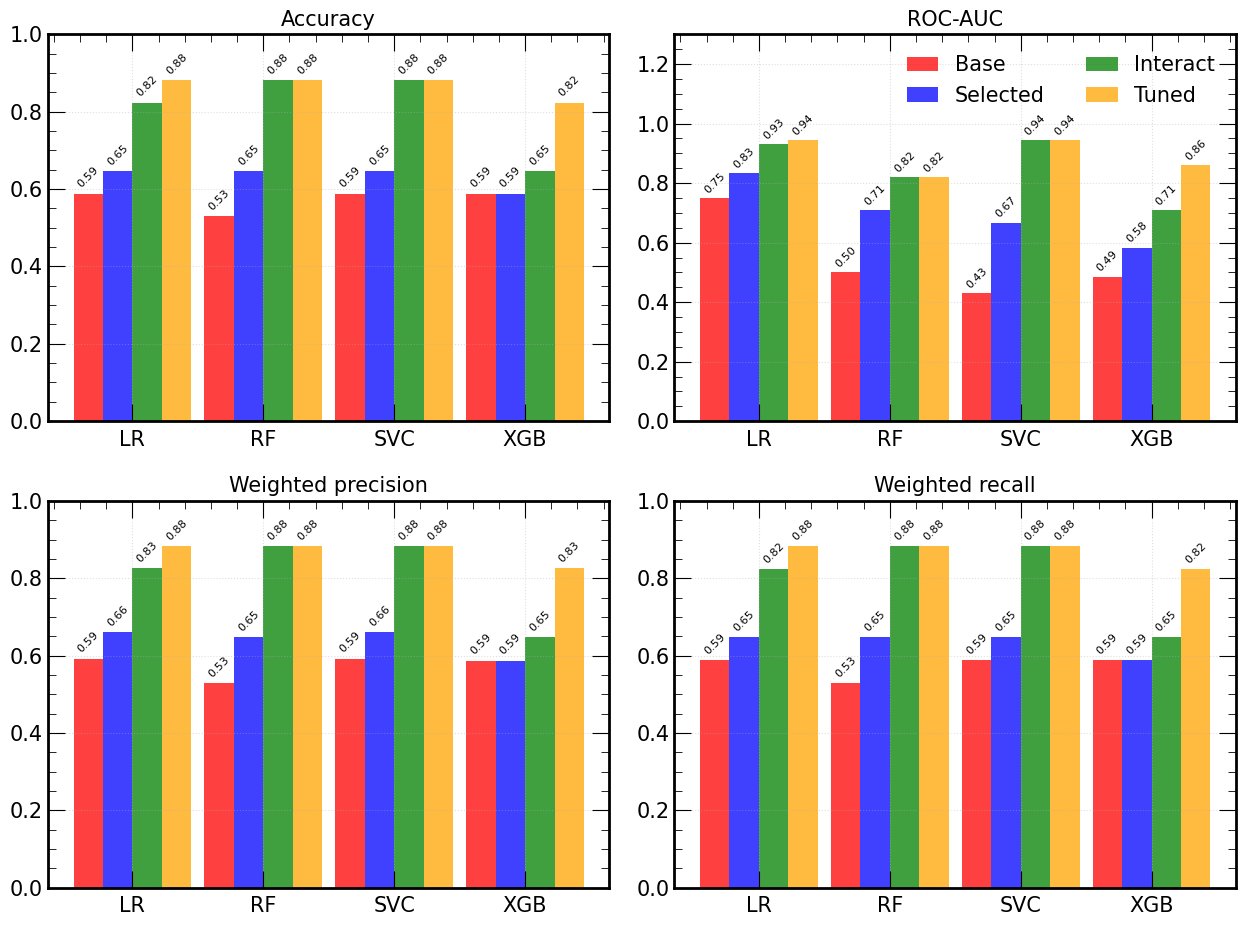

In [35]:
# Compare all model variants: base, selected features, and selected+interactions
import numpy as np

# Define model groups and their tags
model_groups = [
    ("LR", ["lr-loocv", "lr-loocv-sel", "lr-loocv-interact", "lr-loocv-sel-inter-tuned"]),
    ("RF", ["rf-loocv", "rf-loocv-sel", "rf-loocv-sel-interact", "rf-loocv-sel-inter-tuned"]),
    ("SVC", ["svc-loocv", "svc-loocv-sel", "svc-loocv-sel-interact", "svc-loocv-sel-inter-tuned"]),
    ("XGB", ["xgb-loocv", "xgb-loocv-sel", "xgb-loocv-sel-interact", "xgb-loocv-sel-inter-tuned"]),
]

variant_labels = ["Base", "Selected", "Interact", "Tuned"]

# Prepare data
acc, auc, precision, recall = [], [], [], []
for _, tags in model_groups:
    acc_row, auc_row, prec_row, rec_row = [], [], [], []
    for tag in tags:
        m = metrics.get(tag)
        if m is not None:
            report = m["report"]
            acc_row.append(report.loc["accuracy", "precision"])
            auc_row.append(m["roc"]["auc"])
            prec_row.append(report.loc["weighted avg", "precision"])
            rec_row.append(report.loc["weighted avg", "recall"])
        else:
            acc_row.append(np.nan)
            auc_row.append(np.nan)
            prec_row.append(np.nan)
            rec_row.append(np.nan)
    acc.append(acc_row)
    auc.append(auc_row)
    precision.append(prec_row)
    recall.append(rec_row)

acc = np.array(acc)
auc = np.array(auc)
precision = np.array(precision)
recall = np.array(recall)

# Plot grouped bars
fig, ax = plt.subplots(2, 2, figsize=(2*6.4, 2*4.8))

bar_width = 0.225
x = np.arange(len(model_groups))

for i, (metric, data, title) in enumerate([
    (acc, acc, "Accuracy"),
    (auc, auc, "ROC-AUC"),
    (precision, precision, "Weighted precision"),
    (recall, recall, "Weighted recall"),
]):
    row, col = divmod(i, 2)
    for j in range(len(variant_labels)):
        offset = (j - 1.5) * bar_width  # Centre the bars
        bars = ax[row, col].bar(
            x + offset,  
            data[:, j],
            width=bar_width,
            label=variant_labels[j],
            alpha=0.75
        )
        for bar in bars:
            height = bar.get_height()
            if not np.isnan(height):
                ax[row, col].text(
                    bar.get_x() + bar.get_width() / 2., height + 0.01,
                    f"{height:.2f}", ha="center", va="bottom", fontsize=8, rotation=45
                )
    ax[row, col].tick_params(axis='x', which='minor', bottom=False, labelbottom=False)
    ax[row, col].set_xticks(x)
    ax[row, col].set_xticklabels([g[0] for g in model_groups])
    ax[row, col].set_ylim([0, 1])
    #ax[row, col].set_ylabel(title)
    ax[row, col].set_title(title)
    ax[row, col].grid(alpha=0.4)
    if row == 0 and col == 1:
        ax[row, col].set_ylim(0, 1.3)
        ax[row, col].legend(ncols=2, loc="upper right")

plt.tight_layout()
file_name = "../images/metrics_comparison.png"
plt.savefig(file_name)
print(f"✅ Wrote {file_name}")
plt.show()

## Final results

All models except XGBoost converge on the same answer. Are they predicting the same elections? 

Build final results data frame

In [36]:
def format_prediction(correct, prob):
    """Format as with probability of Republican"""
    symbol = "✅" if correct else "❌"
    return f"{symbol} ({prob:.3f})"

final_results = pd.DataFrame({
    "Year": df["Year"],
    "Winner": df["Winner"],
    "Party": df["Party"],
    "LR": [format_prediction(t == p, prob) 
           for t, p, prob in zip(results["lr-loocv-sel-inter-tuned"]["y_test"],
                                  results["lr-loocv-sel-inter-tuned"]["y_pred"],
                                  results["lr-loocv-sel-inter-tuned"]["y_proba"])],
    "RF": [format_prediction(t == p, prob) 
           for t, p, prob in zip(results["rf-loocv-sel-inter-tuned"]["y_test"],
                                  results["rf-loocv-sel-inter-tuned"]["y_pred"],
                                  results["rf-loocv-sel-inter-tuned"]["y_proba"])],
    "SVC": [format_prediction(t == p, prob) 
            for t, p, prob in zip(results["svc-loocv-sel-inter-tuned"]["y_test"],
                                   results["svc-loocv-sel-inter-tuned"]["y_pred"],
                                   results["svc-loocv-sel-inter-tuned"]["y_proba"])],
    "XGB": [format_prediction(t == p, prob) 
            for t, p, prob in zip(results["xgb-loocv-sel-inter-tuned"]["y_test"],
                                   results["xgb-loocv-sel-inter-tuned"]["y_pred"],
                                   results["xgb-loocv-sel-inter-tuned"]["y_proba"])],
})
display(final_results)

file_name = "../results/final_results.csv"
final_results.to_csv(file_name, index=False)
print(f"✅ Wrote {file_name}")

,Year,Winner,Party,LR,RF,SVC,XGB
0,2024,Donald Trump,Republican,✅ (0.510),✅ (0.675),✅ (0.982),✅ (0.750)
1,2020,Joseph Biden,Democratic,✅ (0.493),✅ (0.180),✅ (0.117),✅ (0.187)
2,2016,Donald Trump,Republican,❌ (0.498),❌ (0.140),✅ (0.494),❌ (0.359)
3,2012,Barack Obama,Democratic,✅ (0.493),✅ (0.282),✅ (0.111),✅ (0.305)
4,2008,Barack Obama,Democratic,✅ (0.498),✅ (0.387),✅ (0.405),❌ (0.563)
5,2004,George W. Bush,Republican,✅ (0.504),✅ (0.705),✅ (0.655),✅ (0.757)
6,2000,George W. Bush,Republican,✅ (0.510),✅ (0.670),✅ (0.891),✅ (0.587)
7,1996,William Clinton,Democratic,✅ (0.499),✅ (0.489),✅ (0.529),✅ (0.434)
8,1992,William Clinton,Democratic,✅ (0.484),✅ (0.146),✅ (0.007),✅ (0.306)
9,1988,George Bush,Republican,✅ (0.509),✅ (0.957),✅ (0.790),✅ (0.853)


✅ Wrote ../results/final_results.csv


2016 - Trump (R):

Predicted Left with 86% confidence (0.140 prob of Right). The model was fooled by economic conditions that seem to typically favor Democrats. Trump 2016 was an interesting election driven by factors not captured in macroeconomic data.


1976 - Carter (D):

Predicted Right with 88% confidence. Post-Watergate, post-Vietnam era with unique political circumstances. His long-shot status at the beginning of his campaign led to the common question and eventual nickname "Jimmy Who?". 

## Confidence analysis

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


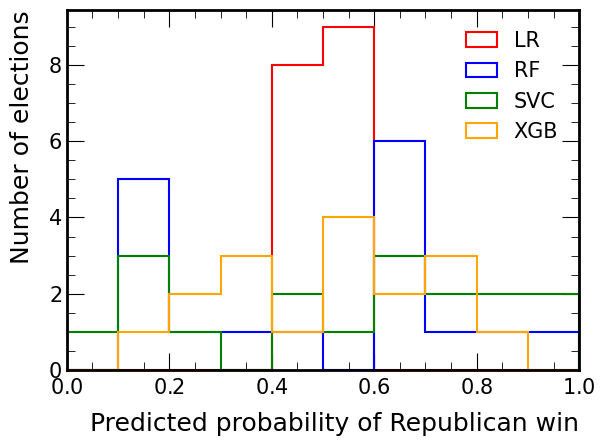

✅ Wrote ../images/predicted_probabilities.png


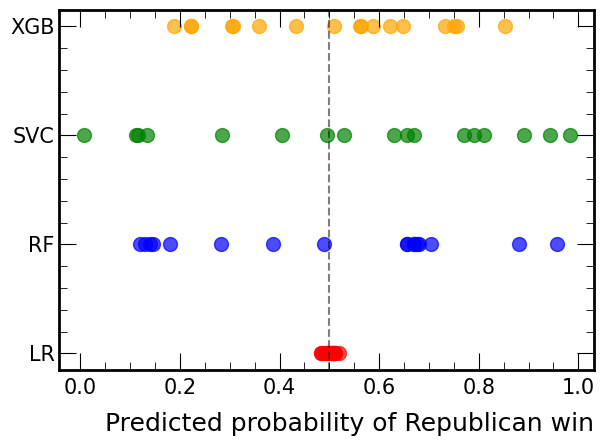

In [66]:

from pyutils.pyplot import Plot


Plot().plot_1D_overlay(
    { 
        "LR" : results["lr-loocv-sel-inter-tuned"]["y_proba"],
        "RF": results["rf-loocv-sel-inter-tuned"]["y_proba"],
        "SVC": results["svc-loocv-sel-inter-tuned"]["y_proba"],
        "XGB": results["xgb-loocv-sel-inter-tuned"]["y_proba"],
    },
    nbins = 10,
    xmin=0,
    xmax=1,
    xlabel="Predicted probability of Republican win",
    ylabel="Number of elections",
    show=True,
)

fig, ax = plt.subplots()
colors = {"LR": "C0", "RF": "C1", "SVC": "C2", "XGB": "C3"}
y_offset = 0

for name, probs in [("LR", results["lr-loocv-sel-inter-tuned"]["y_proba"]),
                    ("RF", results["rf-loocv-sel-inter-tuned"]["y_proba"]),
                     ("SVC", results["svc-loocv-sel-inter-tuned"]["y_proba"]),
                     ("XGB", results["xgb-loocv-sel-inter-tuned"]["y_proba"]),
                    ]:
    ax.scatter(probs, [y_offset]*len(probs), alpha=0.7, 
               s=100, label=name, color=colors[name])
    y_offset += 1

ax.set_xlabel("Predicted probability of Republican win")
ax.set_yticks(range(4))
ax.set_yticklabels(["LR", "RF", "SVC", "XGB"])
ax.axvline(0.5, color="k", linestyle="--", alpha=0.5) # , zorder=0)
plt.tight_layout()
file_name = "../images/predicted_probabilities.png"
plt.savefig(file_name)
print(f"✅ Wrote {file_name}")
plt.show()

## Individual feature importance analysis

In [37]:
a = metrics["lr-loocv-sel-inter-tuned"]["feature_importance"]["Feature"]
b = metrics["rf-loocv-sel-inter-tuned"]["feature_importance"]["Feature"]
c = metrics["svc-loocv-sel-inter-tuned"]["feature_importance"]["Feature"]
d = metrics["xgb-loocv-sel-inter-tuned"]["feature_importance"]["Feature"]

for i in range(len(a)):
    print()
    print("a:", a[i])
    print("b:", b[i])
    print("c:", c[i])
    print("d:", d[i])
    print()


a: Population growth [%]
b: Population growth [%]
c: Population growth [%]
d: Population growth [%]


a: Inflation GDP deflator [%]
b: Inflation GDP deflator [%]
c: Inflation GDP deflator [%]
d: Inflation GDP deflator [%]


a: Gross capital formation [% of GDP]
b: Gross capital formation [% of GDP]
c: Gross capital formation [% of GDP]
d: Gross capital formation [% of GDP]


a: Unemployment [%]
b: Unemployment [%]
c: Unemployment [%]
d: Unemployment [%]


a: Population growth [%] $\times$ Fertility rate [births per woman]
b: Population growth [%] $\times$ Fertility rate [births per woman]
c: Population growth [%] $\times$ Fertility rate [births per woman]
d: Population growth [%] $\times$ Fertility rate [births per woman]


a: Population growth [%] $\times$ Measles immunisation [% children 12-23 months]
b: Population growth [%] $\times$ Measles immunisation [% children 12-23 months]
c: Population growth [%] $\times$ Measles immunisation [% children 12-23 months]
d: Population growth [

Base features actually used in models (8 total):
  Energy use [kg oil per capita]
  Fertility rate [births per woman]
  Gross capital formation [% of GDP]
  Inflation GDP deflator [%]
  Measles immunisation [% children 12-23 months]
  Population growth [%]
  Revenue excluding grants [% of GDP]
  Unemployment [%]

Feature importances by model (normalised):



,LR,RF,SVC,XGB
Energy use [kg oil per capita],0.060795,0.065594,0.061296,0.065413
Fertility rate [births per woman],0.069496,0.063800,0.058606,0.058809
Gross capital formation [% of GDP],0.225281,0.234555,0.236828,0.224805
Inflation GDP deflator [%],0.140208,0.167735,0.081208,0.175989
Measles immunisation [% children 12-23 months],0.122953,0.107791,0.106715,0.167578
Population growth [%],0.152977,0.132104,0.140949,0.108729
Revenue excluding grants [% of GDP],0.064235,0.085106,0.028848,0.066266
Unemployment [%],0.164055,0.143314,0.285551,0.132412


✅ Wrote ../results/base_feature_importances_by_model.csv
✅ Wrote ../images/final_feature_importance_comparison.png


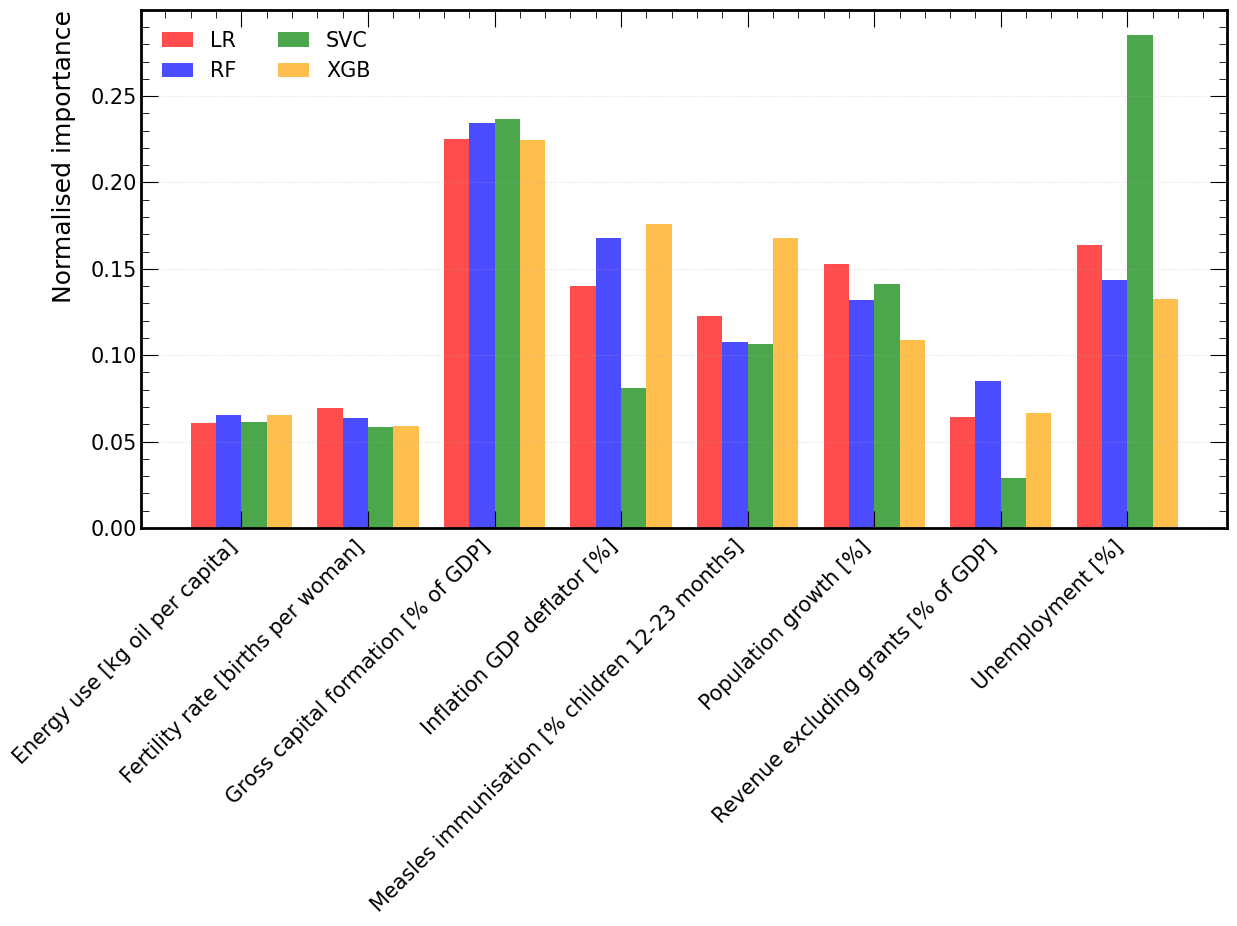

In [38]:
# Get the actual features used in the final models from X_tune
actual_features_used = X_tune.columns.tolist()

# Extract unique base features from the actual features used
base_features_set = set()
for feature in actual_features_used:
    if "$\\times$" in feature:
        # Interaction term - extract both base features
        parts = feature.split("$\\times$")
        base_features_set.add(parts[0].strip())
        base_features_set.add(parts[1].strip())
    else:
        # Direct base feature
        base_features_set.add(feature)

# Convert to sorted list for consistent ordering
base_features = sorted(list(base_features_set))

print(f"Base features actually used in models ({len(base_features)} total):")
for feat in base_features:
    print(f"  {feat}")

# Dictionary to store aggregated importances for each model
model_importances = {}

# Model tags for the final tuned models
model_tags = {
'LR': 'lr-loocv-sel-inter-tuned',
'RF': 'rf-loocv-sel-inter-tuned',
'SVC': 'svc-loocv-sel-inter-tuned',
'XGB': 'xgb-loocv-sel-inter-tuned'
}

for model_name, tag in model_tags.items():
    model = results[tag]["model"]
    # Use X_tune columns which contain the actual features used in training
    feature_names = X_tune.columns

    # Extract raw importances based on model type
    if hasattr(model, 'coef_'):
        # Linear models (LR, SVC) - use absolute values of coefficients
        raw_importance = np.abs(model.coef_[0])
    elif hasattr(model, 'feature_importances_'):
        # Tree-based modeimportance_dfls (RF, XGB)
        raw_importance = model.feature_importances_
    else:
        continue

    # Aggregate importance by base feature
    feature_importance = {feat: 0.0 for feat in base_features}

    for feature, importance in zip(feature_names, raw_importance):
        if "$\\times$" in feature:
            # Interaction term - split equally between base features
            parts = feature.split("$\\times$")
            feature1 = parts[0].strip()
            feature2 = parts[1].strip()

            # Only add if it's one of our base features
            if feature1 in feature_importance:
                feature_importance[feature1] += importance / 2
            if feature2 in feature_importance:
                feature_importance[feature2] += importance / 2
        else:
            # Direct base feature
            if feature in feature_importance:
                feature_importance[feature] += importance
    # Normalise
    total = sum(feature_importance.values())
    if total > 0:
        feature_importance = {k: v/total for k, v in feature_importance.items()}

    model_importances[model_name] = feature_importance

# Create DataFrame
importance_df = pd.DataFrame(model_importances)
importance_df = importance_df.reindex(base_features)

# Display table
print("\nFeature importances by model (normalised):\n")
display(importance_df)

# Save to CSV
file_name = "../results/base_feature_importances_by_model.csv"
importance_df.to_csv(file_name)
print(f"✅ Wrote {file_name}")

fig, ax = plt.subplots(figsize=(2*6.4, 2*4.8))

x = np.arange(len(base_features))
width = 0.2
models = model_tags.keys()

for i, model in enumerate(models):
    values = [importance_df.loc[feat, model] for feat in base_features]
    offset = (i - 1.5) * width
    bars = ax.bar(x + offset, values, width, label=model, alpha=0.7)

ax.tick_params(axis='x', which='minor', bottom=False, labelbottom=False)
ax.set_ylabel('Normalised importance') # , fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(base_features, rotation=45, ha='right')
ax.legend(loc='upper left', ncols=2)
ax.grid(axis='y', alpha=0.4)
plt.tight_layout()

file_name = "../images/final_feature_importance_comparison.png"
plt.savefig(file_name)
print(f"✅ Wrote {file_name}")
plt.show()


In [39]:
base_features

['Energy use [kg oil per capita]',
 'Fertility rate [births per woman]',
 'Gross capital formation [% of GDP]',
 'Inflation GDP deflator [%]',
 'Measles immunisation [% children 12-23 months]',
 'Population growth [%]',
 'Revenue excluding grants [% of GDP]',
 'Unemployment [%]']

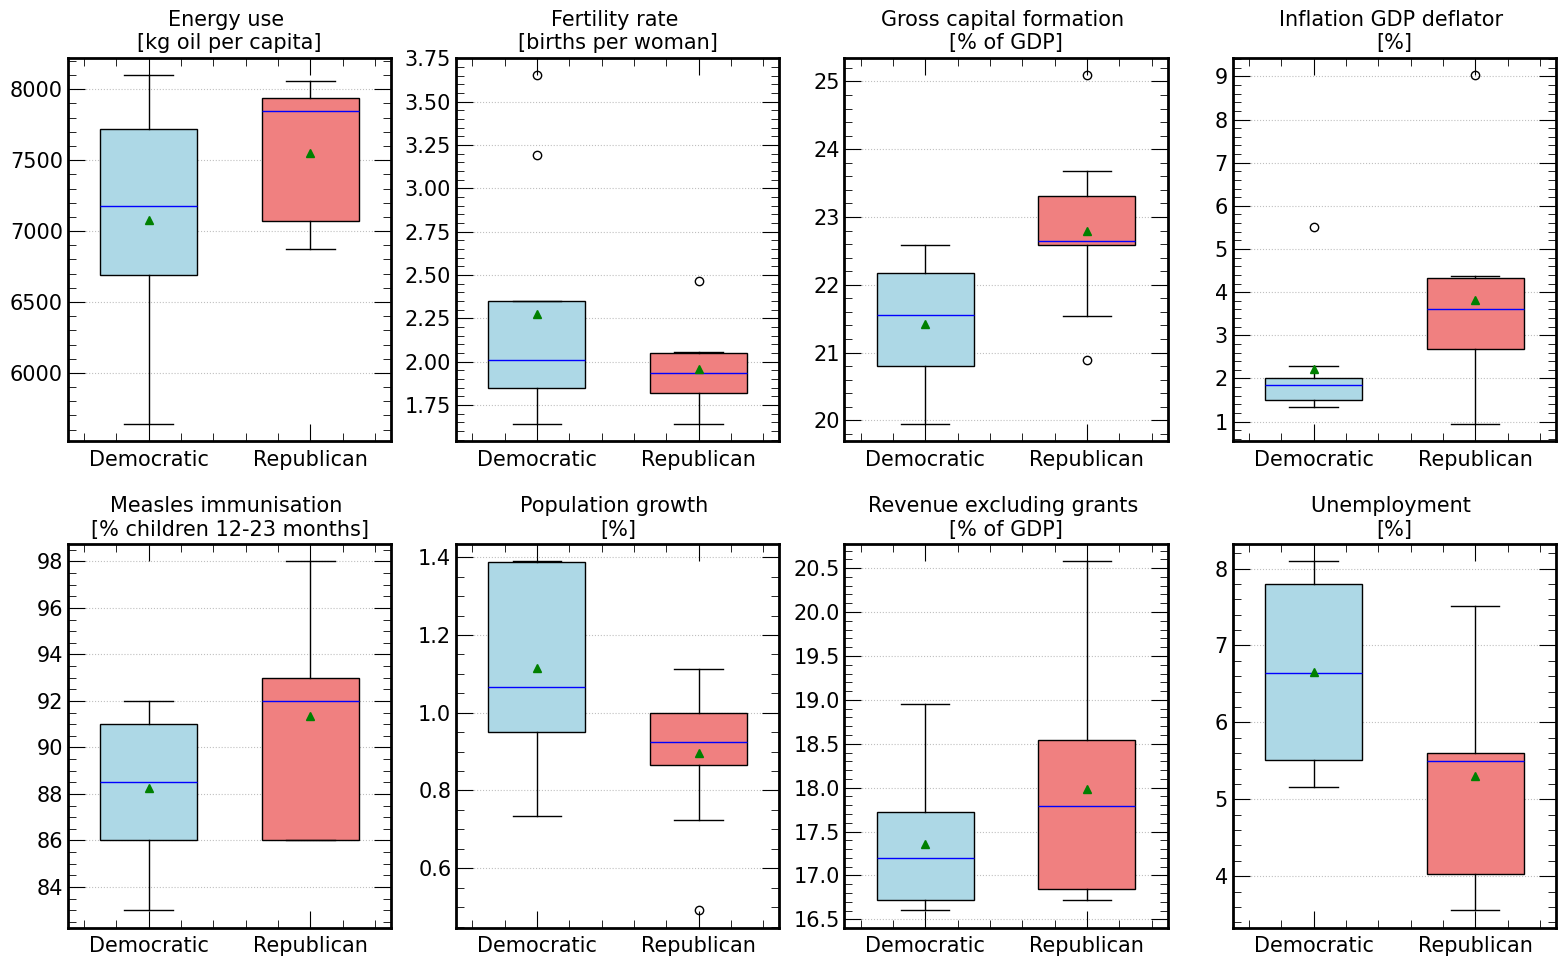

Saved: ../images/box_2x4_indicators_vs_outcome.png


In [40]:

fig, ax = plt.subplots(2, 4, figsize=(16, 10))
axes = ax.flatten()

for i, feature in enumerate(base_features):
    this_ax = axes[i] 
    
    dem_data = df[df["Label"] == 0][feature]
    rep_data = df[df["Label"] == 1][feature]
    
    positions = [1, 2]
    bp = this_ax.boxplot([dem_data, rep_data], positions=positions, widths=0.6, 
                            patch_artist=True, showfliers=True, showmeans=True)
    bp["boxes"][0].set_facecolor("lightblue")
    bp["boxes"][1].set_facecolor("lightcoral")
    
    this_ax.set_xticks(positions)
    this_ax.set_xticklabels(["Democratic", "Republican"])
    this_ax.grid(axis="y")

for i, feature in enumerate(base_features):
    parts = feature.strip().split("[")
    axes[i].set_title(parts[0] + "\n[" + parts[1])

plt.tight_layout()
file_name = "../images/box_2x4_indicators_vs_outcome.png"
plt.savefig(file_name)
plt.show()
print(f"Saved: {file_name}")

In [67]:
summary = []
for feature in base_features:
    dem = df[df["Label"] == 0][feature]
    rep = df[df["Label"] == 1][feature]
    
    summary.append({
        "Feature": feature,
        "Dem_Mean": dem.mean(),
        "Dem_Median": dem.median(),
        "Rep_Mean": rep.mean(),
        "Rep_Median": rep.median(),
        "Mean_Diff": rep.mean() - dem.mean(),
        "Median_Diff": rep.median() - dem.median()
    })

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))

                                       Feature    Dem_Mean  Dem_Median    Rep_Mean  Rep_Median  Mean_Diff  Median_Diff
                Energy use [kg oil per capita] 7079.155920 7180.054603 7548.033427 7849.753970 468.877507   669.699367
             Fertility rate [births per woman]    2.274750    2.011000    1.958167    1.934000  -0.316583    -0.077000
            Gross capital formation [% of GDP]   21.423259   21.560317   22.794960   22.652145   1.371701     1.091829
                    Inflation GDP deflator [%]    2.217337    1.846465    3.818311    3.598391   1.600973     1.751927
Measles immunisation [% children 12-23 months]   88.250000   88.500000   91.333333   92.000000   3.083333     3.500000
                         Population growth [%]    1.115884    1.066206    0.895249    0.925484  -0.220635    -0.140722
           Revenue excluding grants [% of GDP]   17.356843   17.198044   17.983110   17.790710   0.626267     0.592666
                              Unemployment [%]  